# Clustering Comparision

## Preamble

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from sklearn.metrics import homogeneity_score, completeness_score, fowlkes_mallows_score, silhouette_score, davies_bouldin_score
from sklearn.metrics.cluster import contingency_matrix
from src.utils import sankey_plot
import kaleido
from sklearn.preprocessing import StandardScaler
import plotly.io as pio
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
DIR = 'Data/'
DATASET_NAMES = ['PBMC1', 'PBMC2', 'PBMC3','PBMC4']
TOOLS = ['monocle', 'scanpy', 'scvi-tools', 'seurat', 'COTAN']
PARAMS_TUNING = ['default', 'celltypist', 'antibody']

In [156]:
def compute_scores(dir, dataset, labels_df, labels_matched, ground_truth_labels):
    scores = {}
    scores['NMI'] = {}
    scores['ARI'] = {}
    scores['homogeneity'] = {}
    scores['completeness'] = {}
    scores['fowlkes_mallows'] = {}
    for tool in TOOLS:
        scores['NMI'][tool] = normalized_mutual_info_score(labels_pred=labels_df['cluster_'+tool], labels_true=labels_df[f'cluster_{ground_truth_labels}'], average_method='arithmetic')
        scores['ARI'][tool] = adjusted_rand_score(labels_pred=labels_df['cluster_'+tool], labels_true=labels_df[f'cluster_{ground_truth_labels}'])
        scores['homogeneity'][tool] = homogeneity_score(labels_pred=labels_df['cluster_'+tool], labels_true=labels_df[f'cluster_{ground_truth_labels}'])
        scores['completeness'][tool] = completeness_score(labels_pred=labels_df['cluster_'+tool], labels_true=labels_df[f'cluster_{ground_truth_labels}'])
        scores['fowlkes_mallows'][tool] = fowlkes_mallows_score(labels_pred=labels_df['cluster_'+tool], labels_true=labels_df[f'cluster_{ground_truth_labels}'])
    scores_df = pd.DataFrame(scores)
    scores_df.to_csv(f'{dir}{dataset}/scores_{labels_matched}_{ground_truth_labels}.csv')
    scores_df.to_latex(f'{dir}{dataset}/scores_{labels_matched}_{ground_truth_labels}.tex')
    display(scores_df)


def print_scores(dataset,tuning):
    
    
    # concat tools labels
    labels_df = pd.read_csv(f'{DIR}{dataset}/COTAN/{tuning}/clustering_labels.csv', index_col=0)
    labels_df.rename(columns={"cluster": "cluster_COTAN"}, inplace=True)
    #print("labels_df size")
    #print(labels_df.shape)
    for tool in [t for t in TOOLS if t != 'COTAN']:
        tool_labels_df = pd.read_csv(f'{DIR}{dataset}/{tool}/{tuning}/clustering_labels.csv', index_col=0)
        labels_df = labels_df.merge(tool_labels_df, how='inner', on='cell')
        labels_df.rename(columns={"cluster": f"cluster_{tool}"}, inplace=True)
    #    print("labels_df size"+tool)
    #    print(labels_df.shape)
    
    # load and concat celltypist labels
    celltypist_df = pd.read_csv(f'{DIR}{dataset}/celltypist/celltypist_labels.csv', index_col=0)
    celltypist_df.index = celltypist_df.index.str[:-2]
    celltypist_df = labels_df.merge(celltypist_df, how='inner', on='cell')
    celltypist_df.rename(columns={"cluster.ids": f"cluster_celltypist"}, inplace=True)
    celltypist_mapping_df = pd.read_csv(f'{DIR}{dataset}/celltypist/celltypist_mapping.csv', index_col=0)
    #print("celltypist_df size")
    #print(celltypist_df.shape)
    
    # load and concat protein surface labels
    antibody_df = pd.read_csv(f'{DIR}{dataset}/antibody_annotation/antibody_labels_postproc.csv', index_col=0)
    antibody_df = labels_df.merge(antibody_df, how='inner', on='cell')
    antibody_df.rename(columns={"cluster.ids": f"cluster_antibody"}, inplace=True)
    antibody_mapping_df = pd.read_csv(f'{DIR}{dataset}/antibody_annotation/antibody_mapping.csv', index_col=1, encoding='latin1')
    #print("antibody_df size")
    #print(antibody_df.shape)

    # read dataset
    adata = sc.read_10x_mtx(
        f'{DIR}{dataset}/filtered/10X/',
        var_names='gene_symbols',
        cache=False
    )
    # keep only labelled cells
    adata.var_names_make_unique()
    subset_cells = adata.obs_names.isin(labels_df.index)
    adata = adata[subset_cells, :]

    mito_genes = adata.var_names.str.startswith('MT-')
    # for each cell compute fraction of counts in mito genes vs. all genes
    # the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
    adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
    # add the total counts per cell as observations-annotation to adata
    adata.obs['n_counts'] = adata.X.sum(axis=1).A1

    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    adata.raw = adata
    adata = adata[:, adata.var.highly_variable]
    sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver='arpack',n_comps=20)
    pca_matrix = adata.obsm['X_pca']
    scaler = StandardScaler()
    scaled_pca_matrix = scaler.fit_transform(pca_matrix)

    #Custers number
    
    df = {}
    for tool in TOOLS:
        df[tool] = labels_df[f'cluster_{tool}'].unique().shape[0]
    df_size = pd.DataFrame(df, index=[0])
    display(f'{dataset} - number of clusters')
    display(df_size)

    # compute silhouette score
    silhouette = {}
    for tool in TOOLS:
        silhouette[tool] = silhouette_score(scaled_pca_matrix, labels_df[f'cluster_{tool}'])
    if tuning=='celltypist':
        silhouette['celltypist'] = silhouette_score(scaled_pca_matrix, celltypist_df[f'cluster_celltypist'])
    elif tuning=='antibody':
        silhouette['antibody'] = silhouette_score(scaled_pca_matrix, antibody_df[f'cluster_antibody'])
    silhouette_df = pd.DataFrame(silhouette, index=[0])
    silhouette_df.to_csv(f'{DIR}{dataset}/{tuning}_silhouette.csv')
    silhouette_df.to_latex(f'{DIR}{dataset}/{tuning}_silhouette.tex')
    display(f'{dataset} - Silhuette (higher is better)')
    display(silhouette_df)

    #From https://evafast.github.io/blog/2019/06/28/example_content/
    davies_bouldin = {}
    for tool in TOOLS:
        davies_bouldin[tool] = davies_bouldin_score(adata.obsm['X_pca'], labels_df[f'cluster_{tool}'])
    if tuning=='celltypist':
        davies_bouldin['celltypist'] = davies_bouldin_score(adata.obsm['X_pca'], celltypist_df[f'cluster_celltypist'])
    elif tuning=='antibody':
        davies_bouldin['antibody'] = davies_bouldin_score(adata.obsm['X_pca'], antibody_df[f'cluster_antibody'])
    davies_bouldin_df = pd.DataFrame(davies_bouldin, index=[0])
    davies_bouldin_df.to_csv(f'{DIR}{dataset}/{tuning}_davies_bouldin.csv')
    davies_bouldin_df.to_latex(f'{DIR}{dataset}/{tuning}_davies_bouldin.tex')
    display(f'{dataset} - davies_bouldin (lower is better)')
    display(davies_bouldin_df)

    display(f'{dataset} - matching {tuning} labels' if tuning != 'default' else f'{dataset} - default labels')

    # compute scores comparing each tool labels with celltypist labels
    if tuning == 'celltypist' or tuning == 'default':
        compute_scores(DIR, dataset, celltypist_df, tuning, 'celltypist')
        labels = []
        labels_titles = []
        for tool in TOOLS:
            labels.append(celltypist_df[f'cluster_{tool}'].to_list())
            labels_titles.append(tool)
        labels.append(celltypist_df[f'cluster_celltypist'].map(celltypist_mapping_df['go'].to_dict()).to_list())
        labels_titles.append('celltypist')
        title = f'{dataset} - matching {tuning} labels' if tuning != 'default' else f'{dataset} - default labels'
        sankey_plot(labels=labels, labels_titles=labels_titles, title=title, path=f'{DIR}{dataset}/{tuning}_celltypist.html')
    
    # compute scores comparing each tool labels with protein labels
    if tuning == 'antibody' or tuning == 'default':
        compute_scores(DIR, dataset, antibody_df, tuning, 'antibody')
        labels = []
        labels_titles = []
        for tool in TOOLS:
            labels.append(antibody_df[f'cluster_{tool}'].to_list())
            labels_titles.append(tool)
        labels.append(antibody_df[f'cluster_antibody'].map(antibody_mapping_df['go'].to_dict()).to_list())
        labels_titles.append('antibody')
        title = f'{dataset} - matching {tuning} labels' if tuning != 'default' else f'{dataset} - default labels'
        sankey_plot(labels=labels, labels_titles=labels_titles, title=title, path=f'{DIR}{dataset}/{tuning}_antibody.html')

In [157]:
def print_clustering_data(dataset,tuning):
    # concat tools labels
    labels_df = pd.read_csv(f'{DIR}{dataset}/COTAN/{tuning}/clustering_labels.csv', index_col=0)
    labels_df.rename(columns={"cluster": "cluster_COTAN"}, inplace=True)
    display(f'Initial COTAN cluster number:')
    display(labels_df.cluster_COTAN.unique().shape[0])
    #print("labels_df size")
    #print(labels_df.shape)
    for tool in [t for t in TOOLS if t != 'COTAN']:
        tool_labels_df = pd.read_csv(f'{DIR}{dataset}/{tool}/{tuning}/clustering_labels.csv', index_col=0)
        display(f'Initial {tool} cluster number:')
        display(labels_df[labels_df.columns[-1]].unique().shape[0])
        labels_df = labels_df.merge(tool_labels_df, how='inner', on='cell')
        labels_df.rename(columns={"cluster": f"cluster_{tool}"}, inplace=True)
    #    print("labels_df size"+tool)
    #    print(labels_df.shape)
    
    if tuning == 'celltypist' or tuning == 'default':
    # load and concat celltypist labels
        celltypist_df = pd.read_csv(f'{DIR}{dataset}/celltypist/celltypist_labels.csv', index_col=0)
        celltypist_df.index = celltypist_df.index.str[:-2]
        celltypist_df = labels_df.merge(celltypist_df, how='inner', on='cell')
        celltypist_df.rename(columns={"cluster.ids": f"cluster_celltypist"}, inplace=True)
        celltypist_mapping_df = pd.read_csv(f'{DIR}{dataset}/celltypist/celltypist_mapping.csv', index_col=0)
        #print("celltypist_df size")
        #print(celltypist_df.shape)
        labels_cluster_celltypist = np.unique(celltypist_df["cluster_celltypist"])
        for tool in TOOLS:
            labels_cluster_tool = np.unique(celltypist_df[f'cluster_{tool}'])
            cm =contingency_matrix(celltypist_df["cluster_celltypist"], celltypist_df[f'cluster_{tool}'])
            cm = pd.DataFrame(cm,index=labels_cluster_celltypist,columns=labels_cluster_tool)
            display(f'{dataset} - contingency_matrix (rows: cellTypist - cols: {tool})')
            display(cm)

    if tuning == 'antibody' or tuning == 'default':
        #load and concat protein surface labels
        antibody_df = pd.read_csv(f'{DIR}{dataset}/antibody_annotation/antibody_labels_postproc.csv', index_col=0)
        display("Initial antibody cell/cluster table:")
        display(antibody_df["cluster.ids"].value_counts())
        antibody_df = labels_df.merge(antibody_df, how='inner', on='cell')
        antibody_df.rename(columns={"cluster.ids": f"cluster_antibody"}, inplace=True)
        
        antibody_mapping_df = pd.read_csv(f'{DIR}{dataset}/antibody_annotation/antibody_mapping.csv', index_col=1, encoding='latin1')
        labels_cluster_antybody = np.unique(antibody_df["cluster_antibody"])
        for tool in TOOLS:
            labels_cluster_tool = np.unique(antibody_df[f'cluster_{tool}'])
            cm =contingency_matrix(antibody_df["cluster_antibody"], antibody_df[f'cluster_{tool}'])
            cm = pd.DataFrame(cm,index=labels_cluster_antybody,columns=labels_cluster_tool)
            display(f'{dataset} - contingency_matrix (rows: antibody - cols: {tool})')
            display(cm)
        

## Data summary information

### Default parameters

In [158]:
print_clustering_data(tuning = 'default',dataset="PBMC1")

'Initial COTAN cluster number:'

14

'Initial monocle cluster number:'

14

'Initial scanpy cluster number:'

3

'Initial scvi-tools cluster number:'

18

'Initial seurat cluster number:'

13

'PBMC1 - contingency_matrix (rows: cellTypist - cols: monocle)'

1    2    3
1     8  970    1
2   943    0    0
3    47    0    0
4     0   78    0
5   309    0    0
6     0    0  142
7    82    0    0
8   278    0    1
9    81    0    0
10    0  171    0
11   70    0    0
12  240    0    0
13    0   28    0
14    0    0  155
15    2    4    0

'PBMC1 - contingency_matrix (rows: cellTypist - cols: scanpy)'

1    2    3    4    5    6    7    8    9   10   11  12   13  14  15  16  \
1     0    0  246    0  267    0  263    0  200   0    1   0    2   0   0   0   
2    88  321    0  281    1    0    0  241    0   1    0   1    0   1   0   8   
3    45    0    0    0    0    0    0    2    0   0    0   0    0   0   0   0   
4     0    0    2    0    0    0    0    0    0   0    0   0    0   0   0   0   
5   250    5    0    0    0    0    0    2    0   0    0  52    0   0   0   0   
6     0    0    0    0    0    0    0    0    0   0    4   0  138   0   0   0   
7     8    0    0    0    0    0    0    0    0  19    0  37    0  18   0   0   
8     0    0    0    0    0  263    0    0    0  16    0   0    0   0   0   0   
9     2    2    0    5    0    0    0    5    0   0    0   0    0   1   0  66   
10    0    0   75    0    0    0    5    0    0   0    0   0    0   0  91   0   
11    0    0    0    0    0    5    0    0    0  65    0   0    0   0   0   0   
12    6    0    0    0    0    0    0    4    0  82    0  59    0  86   0   3   
13    0    0    0    0    0    0    0    0    0   0    0   0    0   0   0   0   
14    0    0    0    0    0    0    0    0    0   0  154   0    1   0   0   0   
15    3    3    0    0    0    0    0    0    0   0    0   0    0   0   0   0   

    17  18  
1    0   0  
2    0   0  
3    0   0  
4   76   0  
5    0   0  
6    0   0  
7    0   0  
8    0   0  
9    0   0  
10   0   0  
11   0   0  
12   0   0  
13   0  28  
14   0   0  
15   0   0

'PBMC1 - contingency_matrix (rows: cellTypist - cols: scvi-tools)'

1    2    3    4    5    6    7    8    9   10  11  12  13
1   659    0    0    0  289    0    1    0    0  30   0   0   0
2     0  485   48  402    0    2    0    0    0   0   0   6   0
3     0    1   41    5    0    0    0    0    0   0   0   0   0
4     0    0    0    0    6    0    0    0    0  72   0   0   0
5     0    5  288   12    0    4    0    0    0   0   0   0   0
6     0    0    0    0    0    0    1    2  139   0   0   0   0
7     0    0   58    0    0   23    1    0    0   0   0   0   0
8     0    0    0    0    0    0  279    0    0   0   0   0   0
9     0    4    0    2    0    2    0    0    0   0   0  73   0
10    1    0    0    0   78    0    0    0    0   0  92   0   0
11    0    0    0    0    0   67    3    0    0   0   0   0   0
12    0    1   48    1    0  189    0    0    0   0   0   1   0
13    0    0    0    0    0    0    0    0    0   0   0   0  28
14    0    0    0    0    0    1    0  147    7   0   0   0   0
15    0    3    0    0    0    3    0    0    0   0   0   0   0

'PBMC1 - contingency_matrix (rows: cellTypist - cols: seurat)'

1    2    3    4    5    6    7    8    9   10  11
1     0    0  616  361    1    0    0    0    1   0   0
2   798  145    0    0    0    0    0    0    0   0   0
3     1   46    0    0    0    0    0    0    0   0   0
4     0    0    0    4    0    0    0    0    0  74   0
5     0  309    0    0    0    0    0    0    0   0   0
6     0    0    0    0    0    0    0  142    0   0   0
7     0   55    0    0    0   27    0    0    0   0   0
8     0    0    0    0  274    5    0    0    0   0   0
9    78    3    0    0    0    0    0    0    0   0   0
10    0    0    0   43    0    0    0    0  128   0   0
11    0    0    0    0    5   65    0    0    0   0   0
12    7   69    0    0    0  164    0    0    0   0   0
13    0    0    0    0    0    0    0    0    0   1  27
14    0    0    0    0    0    0  153    2    0   0   0
15    5    1    0    0    0    0    0    0    0   0   0

'PBMC1 - contingency_matrix (rows: cellTypist - cols: COTAN)'

1   2    3    4    5   6    7    8   9    10   11  12   13   14
1   35   0   11  648  284   0    0    0   0    0    1   0    0    0
2    0   0    0    0    0   0    0    0   7    0    0   0  807  129
3    0   0    0    0    0   0    0    0   0    0    0  37    2    8
4    0  73    2    3    0   0    0    0   0    0    0   0    0    0
5    0   0    0    0    0   0    0    0   0    0    0   1    0  308
6    0   0    0    0    0   0    0  142   0    0    0   0    0    0
7    0   0    0    0    0   0    0    0   0   25    1   0    0   56
8    0   0    0    0    0   0    0    0  55    4  220   0    0    0
9    0   0    0    0    0   0    0    0  34    1    0   0   45    1
10   0   1  146   23    0   0    0    0   0    0    0   0    1    0
11   0   0    0    0    0   0    0    0   2   67    1   0    0    0
12   0   0    0    0    0   0    0    0   3  175    0   1    5   56
13   0   1    0    0    0  27    0    0   0    0    0   0    0    0
14   0   0    0    0    0   0  152    3   0    0    0   0    0    0
15   0   0    0    0    2   0    0    0   4    0    0   0    0    0

'Initial antibody cell/cluster table:'

cluster.ids
7     1338
8      876
3      748
4      341
9      331
5      211
1      202
6      131
2       62
10      51
12      16
Name: count, dtype: int64

'PBMC1 - contingency_matrix (rows: antibody - cols: monocle)'

1     2    3
1   161     0    0
2     0    43    3
3   600     0    0
4   262     1    0
5   158     0    0
6     1    86    0
7    10  1115    0
8   812     1    1
9     1     0  294
10   44     0    0
12   10     0    0

'PBMC1 - contingency_matrix (rows: antibody - cols: scanpy)'

1    2    3    4    5    6    7    8    9   10   11   12   13  14  15  \
1     7    6    0    4    0    0    0    9    0  23    0    7    0  32   0   
2     0    0    3    0    0    0    0    0    0   0    2    0    3   0  38   
3   366   33    0    5    0    0    0   28    0  43    0  122    0   3   0   
4     0    0    0    0    1  249    0    0    0  13    0    0    0   0   0   
5     9    0    0    0    0    0    0    2    0  64    0   15    0  68   0   
6     1    3    0    0    0    0    0    0    0   0    0    0    0   0   1   
7     1    0  319    0  267    0  267    1  198   0    0    0    0   0  52   
8    18  288    0  277    0    1    0  214    0   3    1    5    0   2   0   
9     0    0    0    0    0    1    0    0    0   1  156    0  137   0   0   
10    0    0    0    0    0    7    0    0    0  36    0    0    0   1   0   
12    0    0    0    0    0   10    0    0    0   0    0    0    0   0   0   

    16  17  18  
1   73   0   0  
2    0   0   0  
3    0   0   0  
4    0   0   0  
5    0   0   0  
6    0  56  26  
7    0  19   1  
8    4   0   1  
9    0   0   0  
10   0   0   0  
12   0   0   0

'PBMC1 - contingency_matrix (rows: antibody - cols: scvi-tools)'

1    2    3    4    5    6    7    8    9   10  11  12  13
1     0    6   12    5    0   62    0    0    0   0   0  76   0
2     2    0    0    0    3    0    0    1    1   0  39   0   0
3     0   49  441   66    0   44    0    0    0   0   0   0   0
4     1    0    0    0    0    0  262    0    0   0   0   0   0
5     0    2   12    1    0  141    0    0    0   0   0   2   0
6     0    1    0    0    0    3    0    0    0  56   1   0  26
7   655    3    0    0  368    0    1    0    0  45  52   0   1
8     0  438   17  349    0    4    3    0    0   0   0   2   1
9     0    0    0    0    0    0    3  148  144   0   0   0   0
10    0    0    1    0    0   37    6    0    0   0   0   0   0
12    0    0    0    0    0    0   10    0    0   0   0   0   0

'PBMC1 - contingency_matrix (rows: antibody - cols: seurat)'

1    2    3    4    5    6    7    8   9   10  11
1    93   17    0    0    0   51    0    0   0   0   0
2     0    0    1    4    0    0    1    1  39   0   0
3    23  540    0    0    0   37    0    0   0   0   0
4     0    0    1    0  260    2    0    0   0   0   0
5     1   28    0    0    0  129    0    0   0   0   0
6     3    1    0    1    0    0    0    0   1  56  25
7     2    1  611  402    1    0    0    0  89  18   1
8   766   41    0    0    1    4    1    0   0   0   1
9     0    0    0    0    2    0  151  142   0   0   0
10    0    0    0    0    8   36    0    0   0   0   0
12    0    0    0    0    8    2    0    0   0   0   0

'PBMC1 - contingency_matrix (rows: antibody - cols: COTAN)'

1   2    3    4    5   6    7    8   9    10   11  12   13   14
1    0   0    0    0    0   0    0    0  36   54    0   1   59   11
2    1   1   40    2    0   0    1    1   0    0    0   0    0    0
3    0   0    0    0    0   0    0    0   0   39    0  38   33  490
4    1   0    0    0    0   0    0    0  48    1  213   0    0    0
5    0   0    0    0    0   0    0    0   1  135    0   0    0   22
6    0  56    1    1    1  25    0    0   3    0    0   0    0    0
7   33  17  118  668  284   1    0    0   0    0    1   0    2    1
8    0   0    0    0    0   1    1    0   9    4    0   0  765   34
9    0   0    0    0    0   0  150  143   0    0    2   0    0    0
10   0   0    0    0    0   0    0    0   4   38    2   0    0    0
12   0   0    0    0    0   0    0    0   4    1    5   0    0    0

In [159]:
print_clustering_data(tuning = 'default',dataset="PBMC2")

'Initial COTAN cluster number:'

17

'Initial monocle cluster number:'

17

'Initial scanpy cluster number:'

2

'Initial scvi-tools cluster number:'

18

'Initial seurat cluster number:'

20

'PBMC2 - contingency_matrix (rows: cellTypist - cols: monocle)'

1    2
1    230    1
2    427    0
3   2139    3
4    700    7
5    316    0
6      0   93
7      0  567
8    674    0
9      0  186
10    52    0
11     0  228
12     0  204
13     0   48
14     0   14
15    80    0
16     0    6

'PBMC2 - contingency_matrix (rows: cellTypist - cols: scanpy)'

1    2    3    4    5    6    7    8    9    10   11   12   13   14  15  \
1     0    0    0    2    0    0    1   22    1    2    5   50    0  148   0   
2     0   91    0  273    0    0    0    3    2    0   56    1    0    1   0   
3   942  508   21  183    0    0    0   21  295    2  100   42    0   26   1   
4     0    0    0    1    0  463    8    2    0  230    0    0    0    2   1   
5     0    0    0    2    0    0    0  266    0    0   42    0    0    6   0   
6     0    0    0    0    5    0    0    0    0    0    0    0    0    0   0   
7     0    0    0    0  466    0    0    0    0    0    0    0   15    0  86   
8     2    1  558    0    0    0    0    3    0    0    0  110    0    0   0   
9     0    0    0    0   12    0    0    0    0    0    0    0  174    0   0   
10    0    0    0    0    0    0    0    0    0   50    2    0    0    0   0   
11    0    0    0    0    0    0  228    0    0    0    0    0    0    0   0   
12    0    0    0    0    0    0  204    0    0    0    0    0    0    0   0   
13    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0   
14    0    0    0    0    0    0    1    0    0    0    0    0    0    0   0   
15    0   25    0   46    0    0    0    1    2    1    2    2    0    1   0   
16    0    0    0    1    0    0    0    0    5    0    0    0    0    0   0   

    16  17  18  
1    0   0   0  
2    0   0   0  
3    0   0   1  
4    0   0   0  
5    0   0   0  
6   88   0   0  
7    0   0   0  
8    0   0   0  
9    0   0   0  
10   0   0   0  
11   0   0   0  
12   0   0   0  
13   0  48   0  
14   0   0  13  
15   0   0   0  
16   0   0   0

'PBMC2 - contingency_matrix (rows: cellTypist - cols: scvi-tools)'

1    2    3    4    5    6    7    8    9    10   11   12  13  14  15  \
1     0    0    0    0    0    0  222    1    2    0    0    4   1   1   0   
2   331    4    1    0    0    0    7   10   53    0    0    1   0  10   4   
3   391  733    2    1   19    1   41  304  158  185    0    2  43  90  75   
4     1    0  675    1    0    8    3    0    0    0    0    0   0   0   0   
5     7    0    1    0    0    0   11    9   66    0    0  151  71   0   0   
6     0    0    0   12    0    0    0    0    0    0    0    0   0   0   0   
7     0    0    0  564    0    0    0    0    0    0    3    0   0   0   0   
8     0    2    0    1  561    0  103    1    0    2    0    1   3   0   0   
9     0    0    0   11    0    0    0    0    0    0  175    0   0   0   0   
10    2    0    4    0    0    0    0    0    0    0    0    0   2   0   0   
11    0    0    0    0    0  228    0    0    0    0    0    0   0   0   0   
12    0    0    0    0    0  204    0    0    0    0    0    0   0   0   0   
13    0    0    0    0    0    0    0    0    0    0    0    0   0   0   0   
14    0    0    0    0    0    0    0    0    0   14    0    0   0   0   0   
15   58    0    1    0    0    0    5    5    1    5    0    0   1   3   0   
16    0    0    0    0    0    0    0    0    0    0    0    0   6   0   0   

    16  17  18  19  20  
1    0   0   0   0   0  
2    0   6   0   0   0  
3    0  71   0   0  26  
4    0   0  19   0   0  
5    0   0   0   0   0  
6   78   0   0   3   0  
7    0   0   0   0   0  
8    0   0   0   0   0  
9    0   0   0   0   0  
10   0   0  44   0   0  
11   0   0   0   0   0  
12   0   0   0   0   0  
13   0   0   0  48   0  
14   0   0   0   0   0  
15   0   1   0   0   0  
16   0   0   0   0   0

'PBMC2 - contingency_matrix (rows: cellTypist - cols: seurat)'

1    2    3    4    5    6    7    8    9    10   11  12  13  14
1      0    4    6    0    0    0  219    0    1    0    0   1   0   0
2      0  400   23    0    0    0    1    0    3    0    0   0   0   0
3   1151  352  550    0    2   15   69    1    0    0    0   2   0   0
4      0    0    2  635    0    0    3    7    0    0    1  59   0   0
5      0   42    0    0    0    0    7    0  267    0    0   0   0   0
6      0    0    0    0   11    0    0    0    0    0    0   0  82   0
7      0    0    0    0  567    0    0    0    0    0    0   0   0   0
8      8    4    2    0    0  541  119    0    0    0    0   0   0   0
9      0    0    0    0   14    0    0    0    0  172    0   0   0   0
10     0    0    0    3    0    0    0    0    0    0    0  49   0   0
11     0    0    0    0    0    0    0   83    0    0  145   0   0   0
12     0    0    0    0    0    0    0  201    1    0    2   0   0   0
13     0    0    0    0    0    0    0    0    0    0    0   0   0  48
14     0    0    0    0    0    0    0    0    0    0    0  14   0   0
15     0    0   77    0    0    0    2    0    0    0    0   1   0   0
16     0    0    0    0    0    0    0    0    0    0    0   6   0   0

'PBMC2 - contingency_matrix (rows: cellTypist - cols: COTAN)'

1   2     3    4   5    6    7    8   9   10  11   12   13  14   15  16  \
1     0   0     0    3   4  220    3    0   0   0   1    0    0   0    0   0   
2     0   0     0  416   9    0    2    0   0   0   0    0    0   0    0   0   
3     0   2  1186  847  31   72    3    0   0   0   0    0    0   0    0   0   
4   639  56     0    0   2    3    0    0   0   0   0    0    0   0    1   5   
5     0   0     0   39   0    7  270    0   0   0   0    0    0   0    0   0   
6     0   0     0    0   0    0    0    0   0  86   0    7    0   0    0   0   
7     1   0     0    0   0    0    0    0   0   0  88  300  174   0    0   3   
8     0   0   568    9   1   96    0    0   0   0   0    0    0   0    0   0   
9     0   0     0    0   0    0    0  154  24   0   0    8    0   0    0   0   
10    1  51     0    0   0    0    0    0   0   0   0    0    0   0    0   0   
11    0   0     0    0   0    0    0    0   0   0   0    0    0   0  145  69   
12    0   0     0    0   0    0    1    0   0   0   0    0    0   0    1  22   
13    0   0     0    0   0    0    0    0   0   0   0    0    0  48    0   0   
14    0   0     0    0   0    0    0    0   0   0   0    0    0   0    0  13   
15    0   1     0    6  72    1    0    0   0   0   0    0    0   0    0   0   
16    0   0     0    1   0    1    0    0   0   0   1    0    3   0    0   0   

     17  
1     0  
2     0  
3     1  
4     1  
5     0  
6     0  
7     1  
8     0  
9     0  
10    0  
11   14  
12  180  
13    0  
14    1  
15    0  
16    0

'Initial antibody cell/cluster table:'

cluster.ids
4     1510
11    1130
8      695
12     570
6      424
13     275
5      197
2      150
10     122
3       84
7       76
Name: count, dtype: int64

'PBMC2 - contingency_matrix (rows: antibody - cols: monocle)'

1    2
2      0  147
3     60   20
4   1480   13
5    196    0
6    416    1
7     68    7
8    681    5
10     0  119
11  1115    9
12   566    4
13     0  271

'PBMC2 - contingency_matrix (rows: antibody - cols: scanpy)'

1    2    3    4    5    6    7    8    9    10   11   12   13   14  15  \
2     0    0    0    0    4    0    0    0    0    0    0    0  141    0   2   
3     0    1    1    0    0    3    0    0    0   54    0    0   18    2   1   
4    89  588    0  478    0    0    0   56   63    0  194   10    1    3   3   
5     7    1   14    2    0    0    0  118    2    2    4   23    0   23   0   
6     0    2    9   13    0    0    1  128    1    0    3  124    0  136   0   
7     1    3   27    3    0    0    0    6    1    0    1   23    0    3   0   
8     0    0    0    0    0  459    4    0    0  220    0    0    2    0   0   
10    0    0    0    0  107    0    0    0    0    0    0    0    3    0   3   
11  843   26    5    5    0    0    5    4  229    0    1    2    0    0   1   
12    2    0  522    0    0    0    2    1    1    2    0   21    0   17   1   
13    0    0    0    0    0    0  263    0    0    0    0    0    7    0   0   

    16  17  18  
2    0   0   0  
3    0   0   0  
4    4   3   1  
5    0   0   0  
6    0   0   0  
7    5   2   0  
8    0   1   0  
10   6   0   0  
11   2   1   0  
12   0   1   0  
13   0   1   0

'PBMC2 - contingency_matrix (rows: antibody - cols: scvi-tools)'

1    2    3    4    5    6    7    8    9    10   11   12   13  14  15  \
2     0    0    0    5    0    0    0    0    0    0  142    0    0   0   0   
3     0    0   55    0    1    0    0    1    0    0   19    0    0   0   0   
4   758  143    0    4    0    0   30  125  259   52    0    5    4  54  26   
5     4    8    1    0    5    0   27    4    6    0    0   36  105   0   0   
6     4    0    0    0   17    0  270    2    9    0    0  112    3   0   0   
7     0    1    0    1   31    0   27    2    1    1    0    5    0   0   0   
8     0    0  622    0    0    4    0    0    0    0    2    0    1   0   0   
10    0    0    0  111    0    0    0    0    0    0    4    0    0   0   0   
11   14  581    0    1    5    5    2  191    5  138    0    0    1  50  51   
12    0    2    1    1  520    2   34    1    0    1    0    0    6   0   0   
13    0    0    0    7    0  263    0    0    0    0    0    0    0   0   0   

    16  17  18  19  20  
2    0   0   0   0   0  
3    0   0   4   0   0  
4    4  23   0   3   3  
5    0   0   0   0   0  
6    0   0   0   0   0  
7    4   0   0   2   0  
8    0   0  56   1   0  
10   4   0   0   0   0  
11   2  54   0   1  23  
12   0   1   0   1   0  
13   0   0   0   1   0

'PBMC2 - contingency_matrix (rows: antibody - cols: seurat)'

1    2    3    4    5    6    7    8    9    10   11  12  13  14
2      0    0    0    0    8    0    0    0    0  139    0   0   0   0
3      0    0    1    9    2    1    1    0    0   18    0  48   0   0
4     65  756  607    0    4    0   10    0   42    0    0   2   4   3
5      6    6    2    0    0   12   65    0  104    0    0   1   0   0
6      0   22    3    0    0    7  267    0  118    0    0   0   0   0
7      2    7    5    0    0   21   30    0    3    0    0   0   5   2
8      0    0    0  627    0    0    0    3    0    2    1  52   0   1
10     0    0    0    0  113    0    0    0    0    3    0   0   3   0
11  1073    4   35    0    1    1    1    4    1    0    1   0   2   1
12     9    0    0    0    1  512   44    1    0    0    1   1   0   1
13     0    0    0    0    7    0    0  159    1    0  103   0   0   1

'PBMC2 - contingency_matrix (rows: antibody - cols: COTAN)'

1   2     3     4    5    6    7    8   9   10  11  12  13  14   15  16  \
2     0   0     0     0    0    0    0  137   4   0   2   3   1   0    0   0   
3     8  49     1     2    0    1    0    1  17   0   1   0   0   0    0   0   
4     0   0    76  1235  110   16   44    0   0   4   3   0   1   3    0   1   
5     0   0    19     6    1   65  105    0   0   0   0   0   0   0    0   0   
6     0   0    11    23    1  261  120    0   0   0   1   0   0   0    0   0   
7     0   0    32    16    1   15    4    0   0   5   0   0   0   2    0   0   
8   630  50     0     0    0    0    0    0   2   0   0   0   0   1    1   2   
10    0   0     0     0    0    0    0    4   0   5   1  76  33   0    0   0   
11    0   0  1082    27    4    1    1    0   0   2   1   0   0   1    1   3   
12    0   1   526     0    0   38    1    0   0   0   0   0   0   1    1   1   
13    0   0     0     0    0    0    1    0   0   0   5   0   0   1  102  29   

     17  
2     0  
3     0  
4     0  
5     0  
6     0  
7     0  
8     0  
10    0  
11    1  
12    1  
13  133

In [160]:
print_clustering_data(tuning = 'default',dataset="PBMC3")

'Initial COTAN cluster number:'

32

'Initial monocle cluster number:'

32

'Initial scanpy cluster number:'

3

'Initial scvi-tools cluster number:'

22

'Initial seurat cluster number:'

17

'PBMC3 - contingency_matrix (rows: cellTypist - cols: monocle)'

1     2    3
1   3021     0    0
2      1  1471    0
3      6     1  655
4   1100     0    0
5   1183    26   33
6      0   156    0
7   1112     1    0
8    484     0    0
9      0     0  396
10     0   408    0
11   430     0    0
12     0     0    8
13   233     0    0
14   111     0    0
15     4    16    0
16     0    11    0
17     0     8    0
18     0    57    0
19     0    12    0

'PBMC3 - contingency_matrix (rows: cellTypist - cols: scanpy)'

1    2    3    4    5    6    7    8    9    10  ...   13   14   15  \
1   1401    0  153    0    0   29   26  534  121  429  ...    1    0  100   
2      0    0    0    0  816    0    0    0    0    0  ...    0    2    0   
3      0    0    0  543    0    0    0    0    5    0  ...    0    0    0   
4     26    0    0    0    0  806   12    5   29    6  ...    0    0  155   
5      0  961    0    0    0    0    3    0    0    0  ...  216    0    0   
6      0    0    0    0    8    0    0    0    0    0  ...    0    0    0   
7      0    0  683    0    0    0    7  128  236   15  ...    0    0    6   
8      0    0    0    0    0    0  423    0   32    0  ...    4    0    6   
9      0    0    0  395    0    0    0    0    0    0  ...    0    0    0   
10     0    0    0    0   90    0    0    0    0    0  ...    0  311    0   
11     0    2    0    0    0    0  281    2   54    0  ...    4    0   42   
12     0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
13    12    0  116    0    0    0    1   52    9   11  ...    0    0    1   
14     0    5    1    0    0    0    5    0    3    0  ...   97    0    0   
15     0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
16     0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
17     0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
18     0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
19     0    0    0    0    0    0    0    0    0    0  ...    0    0    0   

     16   17   18  19  20  21  22  
1     0    0    0   0   0  28   0  
2   227    0    5   0  35   0   0  
3     0  111    0   0   2   0   0  
4     0    0    0   0   0   1   0  
5    29   33    0   0   0   0   0  
6     0    0  147   0   0   0   0  
7     1    0    0   0   0   0   0  
8     0    0    0   0   0   0   0  
9     0    1    0   0   0   0   0  
10    1    0    1   0   1   0   0  
11    0    0    0   0   0   0   0  
12    0    8    0   0   0   0   0  
13    0    0    0   0   0   0   0  
14    0    0    0   0   0   0   0  
15    0    0    0   0   0   0  20  
16   11    0    0   0   0   0   0  
17    0    0    8   0   0   0   0  
18    0    0    0  57   0   0   0  
19    0   12    0   0   0   0   0  

[19 rows x 22 columns]

'PBMC3 - contingency_matrix (rows: cellTypist - cols: scvi-tools)'

1     2     3     4    5    6    7    8    9    10   11   12   13  14  \
1   740  1603     2     1    1   40   86   23  248    1  197   79    0   0   
2     0     0  1460     0    1    0    0    0    0    3    0    0    8   0   
3     0     0     4     2  655    0    1    0    0    0    0    0    0   0   
4     6    11     0     1    1  912  162    2    1    0    4    0    0   0   
5     0     0    29  1165   31    0    7    1    0    0    0    0    0   8   
6     0     0    10     0    0    0    0    0    0    0    0    0  146   0   
7   883    14     1     0    0    1   25   29   80    0   70   10    0   0   
8    24     0     0     6    0    1    5  313    0    0    0  135    0   0   
9     0     0     0     0  396    0    0    0    0    0    0    0    0   0   
10    0     0    97     0    0    0    0    0    0  311    0    0    0   0   
11   10     0     0     2    0    2  408    2    0    0    1    4    0   1   
12    0     0     0     0    0    0    0    0    8    0    0    0    0   0   
13  174    26     0     0    0    0    3    0   25    0    5    0    0   0   
14    0     0     1    19    0    0    1    0    0    0    0    0    0  90   
15    0     0     0     0    0    0    0    0    0    0    0    0    0   0   
16    0     0     0     0    0    0    0    0    0    0    0    0    0   0   
17    0     0     0     0    0    0    0    0    0    0    0    0    8   0   
18    0     0     1     0    1    0    0    0    0    0    0    0    0   0   
19    0     0     0     0    0   12    0    0    0    0    0    0    0   0   

    15  16  17  
1    0   0   0  
2    0   0   0  
3    0   0   0  
4    0   0   0  
5    0   1   0  
6    0   0   0  
7    0   0   0  
8    0   0   0  
9    0   0   0  
10   0   0   0  
11   0   0   0  
12   0   0   0  
13   0   0   0  
14   0   0   0  
15   0  20   0  
16   0   0  11  
17   0   0   0  
18  55   0   0  
19   0   0   0

'PBMC3 - contingency_matrix (rows: cellTypist - cols: seurat)'

1    2     3     4    5    6    7    8    9    10   11   12   13   14  \
1   1740  415     0     0  681   20  162    0    3    0    0    0    0    0   
2      0    0  1013     0    0    0    0    0    0    0    0  227    0  229   
3      0    0     0     0    0    0    2  535    0    2    0    1    2    0   
4     16    6     0     0    3  886  188    0    0    0    0    0    0    0   
5      0    1     4  1043    0    0    2    1    1    0    0   24  136    0   
6      0    0     7     0    0    0    0    0    0    0    0    0    0    0   
7      0  980     0     0  108    0   18    0    7    0    0    0    0    0   
8      0   18     0     3    0    0    8    0  454    0    0    0    1    0   
9      0    0     0     0    0    0    0   57    0  336    0    0    0    0   
10     0    0    84     0    0    0    0    0    0    0  319    1    0    4   
11     0   14     0     0    0    2  411    0    3    0    0    0    0    0   
12     0    0     0     0    0    0    0    7    0    0    0    0    0    0   
13    13    5     0     0  208    0    7    0    0    0    0    0    0    0   
14     0    0     0     2    0    0    0    0    0    0    0    0  109    0   
15     0    0     0     0    0    0    0    0    0    0    0    0    0    0   
16     0    0     0     0    0    0    0    0    0    0    0    0    0    0   
17     0    0     0     0    0    0    0    0    0    0    0    0    0    0   
18     0    0     0     0    0    0    0    0    0    0    0    0    0    0   
19     0    0     0     0    0    0    0    0    0    0    0    0    0    0   

     15   16  17  18  
1     0    0   0   0  
2     3    0   0   0  
3     0  120   0   0  
4     0    1   0   0  
5     0   30   0   0  
6   149    0   0   0  
7     0    0   0   0  
8     0    0   0   0  
9     0    3   0   0  
10    0    0   0   0  
11    0    0   0   0  
12    0    1   0   0  
13    0    0   0   0  
14    0    0   0   0  
15    0    0   0  20  
16    0    0   0  11  
17    8    0   0   0  
18    5    0  52   0  
19    0    0   0  12

'PBMC3 - contingency_matrix (rows: cellTypist - cols: COTAN)'

1    2    3    4     5    6    7    8    9    10  ...  23   24   25   26  \
1    1   48    6  205  1790   15    4   53  199  154  ...   0    0    0    0   
2    0    0    0    0     0    0    0    0    0    0  ...   0    1    0    0   
3    0    2    0    0     0    0    0    1    1    0  ...  67  125  220  131   
4    0  152    1   89    18  805    0    2    7   20  ...   0    0    0    0   
5    1    0    0    1     0    0    1    1    0    0  ...   3    0    3    0   
6    0    0    0    0     0    0    0    0    0    0  ...   0    0    0    0   
7    0   12    9   26     0    0    4  431  546   27  ...   0    0    0    0   
8    0    4  465    0     0    0    0    1    8    0  ...   0    0    0    0   
9    0    0    0    0     0    0    0    0    0    0  ...   0    0   30   15   
10   0    0    0    0     0    0    0    0    0    0  ...   0    0    0    0   
11  83  272    2    9     0    1    0    0    7    8  ...   0    0    0    0   
12   0    0    0    0     0    0    0    0    0    0  ...   0    0    0    0   
13   0    0    0    4     5    0  139    3    1    6  ...   0    0    0    0   
14   0    0    0    1     0    0    0    0    1    0  ...   0    0    0    0   
15   0    4    0    0     0    0    0    0    0    0  ...   0    0    0    0   
16   0    0    0    0     0    0    0    0    0    0  ...   0    0    0    0   
17   0    0    0    0     0    0    0    0    0    0  ...   0    0    0    0   
18   0    0    0    0     0    0    0    0    0    0  ...   0    0    0    0   
19   0    0    0    0     0    0    0    0    0    0  ...   0    0    0    0   

    27  28   29    30  31  32  
1    0   0    0     0   2   0  
2    2   0    0     0   0   0  
3    0   0    2     0   0   0  
4    0   0    0     0   0   0  
5   30   4  138  1025   0   0  
6    0   0    0     0   0   0  
7    0   0    1     0   0   0  
8    0   0    2     3   0   0  
9    0   0    0     0   0   0  
10   0   0    0     0   0   0  
11   0   0   14     1  32   0  
12   0   0    0     0   8   0  
13   0   0   10     0   0   0  
14   0  86   17     6   0   0  
15   0   0    0     0  16   0  
16   0   0    0     0  11   0  
17   0   0    0     0   0   0  
18   0   0    0     0   0  52  
19   0   0    1     0  11   0  

[19 rows x 32 columns]

'Initial antibody cell/cluster table:'

cluster.ids
9     2220
10    1635
7     1271
13    1067
5     1010
12     909
6      744
2      271
4      214
14     168
3      149
23     133
22      71
Name: count, dtype: int64

'PBMC3 - contingency_matrix (rows: antibody - cols: monocle)'

1     2     3
2      3   265     0
3    132    13     3
4    209     2     1
5    993    14     1
6    741     0     0
7      4  1226     0
9   2201     9     1
10  1616    12     3
12   905     2     1
13     2    43  1002
14   141    23     1
22    70     1     0
23   130     0     0

'PBMC3 - contingency_matrix (rows: antibody - cols: scanpy)'

1    2    3    4    5    6    7    8    9    10  ...   13   14   15  \
2      0    1    0    0   17    0    0    0    0    0  ...    1  223    0   
3      0   14    2    0    0    1    5    0    3    0  ...  106   12    0   
4      4    0    5    0    0   50   25   10   28   15  ...    1    0   57   
5      0  912    0    0    0    0    2    0    0    0  ...   80   10    0   
6      1    0    8    0    0    9  433   11   75    1  ...    3    0  151   
7      0    0    1    0  735    0    0    1    0    0  ...    0   20    0   
9     92    0  808    1    0    1   26  593  323  196  ...    0    3   19   
10  1252    2    4    0    0   15    3   18    4  205  ...    3    1    5   
12    25    1    0    0    1  737   34    0    8    2  ...    6    0   40   
13     0    0    0  873    1    0    1    0    1    0  ...    0    6    0   
14     0   17    0    0    0    0    4    0    2    1  ...  116   20    0   
22    10    0    9    0    0    0    2   18    6   19  ...    0    0    1   
23     0    0   90    0    0    0    0   18    1    2  ...    0    0    0   

     16   17  18  19  20  21  22  
2    25    0   0   1   0   0   0  
3     0    4   0   0   0   0   0  
4     0    1   2   0   0   1   0  
5     2    1   0   0   0   0   1  
6     1    0   0   0   0   0   0  
7   167    0  28   2   0   0   1  
9     1    0   5   0   0   7   0  
10    3    6   4   2   0  20   2  
12    1    1   0   0   0   0   0  
13    1  128   2   2  30   0   0  
14    1    1   0   3   0   0   0  
22    0    0   0   1   0   1   0  
23    0    0   0   0   0   0   0  

[13 rows x 22 columns]

'PBMC3 - contingency_matrix (rows: antibody - cols: scvi-tools)'

1     2     3    4    5    6    7    8    9    10   11  12  13  14  15  \
2      0     0    42    2    0    0    0    0    0  223    0   0   0   0   1   
3      3     0     1   48    2    1    6    1    0   12    0   0   0  74   0   
4     18     8     1    0    2   76   80   18    0    0    7   0   2   0   0   
5      0     0     1  979    1    0    0    0    0   10    0   0   0  14   0   
6     14     1     1    1    0   23  464  222    0    0    6   6   0   3   0   
7      2     0  1182    0    0    0    0    0    0   18    0   0  26   0   1   
9   1524   275     1    0    2    1   26   47  171    3  134  22   5   0   0   
10    52  1281     1    6    4   15    4    2  149    2  101   4   6   0   2   
12     0     5     2    4    1  816   67    5    2    0    1   5   0   0   0   
13     0     0    31    1  995    0    1    1    8    7    0   0   2   0   1   
14     0     0     1  129    1    0    0    3    0   20    0   1   0   7   3   
22    39    14     0    0    0    0    0    4    4    0    6   3   0   0   1   
23   111     2     0    0    0    0    0    0   13    0    4   0   0   0   0   

    16  17  
2    0   0  
3    0   0  
4    0   0  
5    2   1  
6    0   0  
7    1   0  
9    0   0  
10   2   0  
12   0   0  
13   0   0  
14   0   0  
22   0   0  
23   0   0

'PBMC3 - contingency_matrix (rows: antibody - cols: seurat)'

1     2    3    4    5    6    7    8    9    10   11   12   13   14  \
2      0     0   18    1    0    0    0    0    1    0  226   20    1    0   
3      0     3    0   25    0    1    1    0    2    0   12    0  101    0   
4     11    28    0    0   12   48   97    0   12    0    0    0    1    0   
5      0     0    0  980    0    0    0    0    0    0   10    1   14    0   
6      1    22    0    0    6   16  468    0  225    0    0    1    2    0   
7      0     2  873    0    0    0    0    0    0    0   22  139    0  164   
9    129  1302    0    0  716    0   31    1   23    0    3    1    0    0   
10  1543     8    1    2   46    3    6    0    2    0    0    3    3    0   
12     6     0    1    0    3  816   72    0    4    0    0    1    4    0   
13     0     0    1    1    0    0    0  549    1  327    7   30    0    1   
14     0     1    0   14    1    0    0    0    3    0   20    1  121    0   
22    12    19    0    0   34    0    3    0    2    0    0    0    0    0   
23     0     4    0    0  126    0    0    0    0    0    0    0    0    0   

    15   16  17  18  
2    0    0   1   0  
3    0    2   0   1  
4    2    1   0   0  
5    0    1   0   2  
6    0    0   0   0  
7   27    0   2   1  
9    5    0   0   0  
10   4    4   2   4  
12   0    1   0   0  
13   2  126   2   0  
14   0    1   3   0  
22   0    0   1   0  
23   0    0   0   0

'PBMC3 - contingency_matrix (rows: antibody - cols: COTAN)'

1    2    3    4     5    6    7    8    9    10  ...  23   24   25   26  \
2    0    0    0    0     0    0    0    0    0    0  ...   0    0    0    0   
3    1    0    1    3     0    1    0    0    1    0  ...   1    0    0    0   
4    3   29   15   13    15   50    2    9   15   44  ...   0    0    0    0   
5    0    0    0    1     0    0    0    0    0    0  ...   0    0    1    0   
6   62  357  227    8     1   13    1   14   11    4  ...   0    0    0    0   
7    0    0    0    1     0    0    0    1    0    0  ...   0    0    0    0   
9    1   21   28  159   158    0   30  440  716  134  ...   0    0    1    0   
10   0    5    3    3  1550    3    0    6    2    5  ...   0    0    0    0   
12   6   47    4   79     5  739    0    0    1    3  ...   0    0    0    0   
13   0    0    1    0     0    0    0    0    1    0  ...  65  116  233  128   
14   0    0    3    0     0    0    1    1    1    0  ...   0    0    0    0   
22   0    0    2    2    19    0    1    8    6    9  ...   0    0    0    0   
23   0    0    0    4     0    0  109    4    0    1  ...   0    0    0    0   

    27  28   29   30  31  32  
2   14   0    1    2   0   1  
3    0  72   28   25   1   0  
4    0   0    2    0   1   0  
5   12  11    2  968   2   0  
6    0   1   15    0  18   0  
7    1   0    0    0   1   2  
9    0   0    8    0   2   0  
10   0   0    4    2   2   2  
12   0   0    5    0   6   0  
13   1   1    0    0   8   2  
14   0   4  116   14   0   3  
22   0   0    0    0   0   1  
23   0   0    0    0   0   0  

[13 rows x 32 columns]

In [161]:
print_clustering_data(tuning = 'default',dataset="PBMC4")

'Initial COTAN cluster number:'

24

'Initial monocle cluster number:'

24

'Initial scanpy cluster number:'

3

'Initial scvi-tools cluster number:'

22

'Initial seurat cluster number:'

16

'PBMC4 - contingency_matrix (rows: cellTypist - cols: monocle)'

1     2    3
1    407     0    0
2     11     0  797
3   1330     1    0
4    108     0    0
5      9  2178   13
6    308     0    0
7     77     0    0
8    538     0    0
9    358     1    0
10     0   307    0
11     1     1  222
12     0    28    0
13     8     3    2
14   106     0    0
15     0    92    1
16     0    59    0

'PBMC4 - contingency_matrix (rows: cellTypist - cols: scanpy)'

1    2    3    4    5    6    7    8    9    10  ...   13  14   15   16  \
1    10    0    0    0    0    0    0  384    1    0  ...    0   6    0    0   
2     0  673    0    0    0    0    0    0    1    0  ...    0   0    0    0   
3   300    0    0    0  496  385    0    1    0    0  ...  136  10    3    0   
4     0    0    0    0    0    0    0    6   10    0  ...    0   7    0    0   
5     1    0  596  456    0    0  427    0    0  281  ...    0   0    0  169   
6     7    0    0    0    4    3    0    0    0    0  ...    8  99  187    0   
7     3    0    0    0    0    0    0    1    0    0  ...    0  67    0    0   
8   462    0    0    0    8   46    0    1    0    0  ...   19   2    0    0   
9     0    0    0    0    0    0    0    5  348    0  ...    1   0    0    0   
10    0    0    0   74    0    0    1    0    0    2  ...    0   0    0   10   
11    0   46    0    0    0    0    0    0    0    0  ...    0   0    0    0   
12    0    0    0    0    0    0    0    0    0    0  ...    0   0    0    0   
13    7    0    0    0    0    0    0    0    0    0  ...    6   0    0    0   
14   42    0    0    0    1   13    0    1    0    0  ...   47   2    0    0   
15    0    0    0    0    0    0    0    0    0    1  ...    0   0    0    2   
16    0    0    0    0    0    0    0    0    0    0  ...    0   0    0    0   

    17   18  19  20  21  22  
1    0    1   5   0   0   0  
2    0    0   0   0   0  34  
3    0    0   0   0   0   0  
4    0    0  85   0   0   0  
5   76  145   0  48   0   0  
6    0    0   0   0   0   0  
7    0    0   6   0   0   0  
8    0    0   0   0   0   0  
9    0    0   5   0   0   0  
10   2    1   0   1   0   0  
11   1    0   0   0   0   5  
12   0    0   0  28   0   0  
13   0    0   0   0   0   0  
14   0    0   0   0   0   0  
15  88    2   0   0   0   0  
16   0    0   0   0  59   0  

[16 rows x 22 columns]

'PBMC4 - contingency_matrix (rows: cellTypist - cols: scvi-tools)'

1    2    3    4    5    6    7    8    9    10   11  12  13  14  15  16
1     0    0    4    1    0    0    1    0  315    0    0   0  86   0   0   0
2   800    0    2    1    0    0    2    0    1    0    1   0   1   0   0   0
3     0  939  357    2    0    0   20    0    1    0    0   0   0   0   0  12
4     0    0    0    0    0    0  105    2    0    0    0   0   1   0   0   0
5     4    0    1  805  746  413    0    4    2    1  167  15   1  41   0   0
6     0    8    8    0    0    0  291    0    1    0    0   0   0   0   0   0
7     0    0    3    0    0    0   67    1    6    0    0   0   0   0   0   0
8     0   31  483    0    0    0    3    0    6    0    0   0   0   0   0  15
9     0    0    1    2    0    0    0  355    0    0    0   0   1   0   0   0
10    0    0    0   14    0   94    1    0    0  194    4   0   0   0   0   0
11  217    0    0    0    0    0    0    0    0    0    7   0   0   0   0   0
12    0    0    0    0    0    0    0    0    0    0    0   0   0  28   0   0
13    0    1    1    0    0    0    0    6    0    0    0   0   0   0   5   0
14    1    9   89    0    0    0    4    0    1    0    0   0   0   0   0   2
15    0    0    0    2    0    3    0    0    0    0    1  87   0   0   0   0
16    0    0    0    0    0    0    0    0    0    0    0   1   0   0  58   0

'PBMC4 - contingency_matrix (rows: cellTypist - cols: seurat)'

1    2    3    4    5    6    7    8    9    10   11   12   13   14  15  \
1     5    0    0    0    0    0  398    0    0    4    0    0    0    0   0   
2     0    0    0    0  632    0    1    0  122    1    0    0    0    0   0   
3   356  854    0    0    0    0    0    0    0    2  116    0    3    0   0   
4     0    0    0    0    0    0    0    1    0  107    0    0    0    0   0   
5     2    0  780  723    0  447    2    0    2    0    1    1    0  136  28   
6    31   15    0    0    0    0    0    0    0   68    5    0  189    0   0   
7     3    0    0    0    0    0    3    0    0   69    2    0    0    0   0   
8   525    0    0    0    0    0    1    0    0    2   10    0    0    0   0   
9     0    0    0    0    0    0    3  354    1    0    1    0    0    0   0   
10    0    0    0    7    0   86    0    0    0    0    0  213    0    1   0   
11    0    0    0    0    1    0    0    0  223    0    0    0    0    0   0   
12    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0   
13   10    0    0    0    0    0    0    1    0    0    0    0    0    0   1   
14    4    0    0    0    0    0    0    0    0    1  101    0    0    0   0   
15    0    0    0    1    0    1    0    0    0    0    0    0    0    0  90   
16    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0   

    16  17  18  19  
1    0   0   0   0  
2    0   0  52   0  
3    0   0   0   0  
4    0   0   0   0  
5   35   0   0  43  
6    0   0   0   0  
7    0   0   0   0  
8    0   0   0   0  
9    0   0   0   0  
10   0   0   0   0  
11   0   0   0   0  
12  28   0   0   0  
13   0   0   1   0  
14   0   0   0   0  
15   0   0   0   1  
16   0  59   0   0

'PBMC4 - contingency_matrix (rows: cellTypist - cols: COTAN)'

1    2    3    4    5    6    7   8   9   10  ...  15  16  17  18   19  \
1    0    0    0    0    0    0    0   0   0   0  ...   0   0   0   0    1   
2    0    0    0    0    0    0    0   0   2  45  ...   0   0   0   0    1   
3    0    0    0    0    0    0    0   0   0   0  ...   0   0   1   0    0   
4    0    0    0    0    0    0    0   0   0   0  ...   0   0   0   0  105   
5   40  131  724  199  332  741    1  27   0   0  ...   0   0   0   0    0   
6    0    0    0    0    0    0    0   0   0   0  ...   0   0   0   0    0   
7    0    0    0    0    0    0    0   0   0   0  ...   0   0   0   0    3   
8    0    0    0    0    0    0    0   0   0   0  ...   0   0   0   0    0   
9    0    0    0    0    0    0    0   0   0   0  ...   0   0  55  36  118   
10   0    1    6    0   83    2  215   0   0   0  ...   0   0   0   0    0   
11   0    0    0    0    0    0    0   0  24   0  ...   0   0   0   0    0   
12   0    0    0    0    0    0    0   0   0   0  ...   0  28   0   0    0   
13   0    0    0    0    0    0    0   1   0   1  ...   0   0   8   0    0   
14   0    0    0    0    0    0    0   0   0   0  ...   0   0   0   0    0   
15   1    0    1    0    1    0    0  90   0   0  ...   0   0   0   0    0   
16   0    0    0    0    0    0    0   0   0   0  ...  59   0   0   0    0   

     20   21  22   23   24  
1     0  402   0    0    4  
2     0    1   0    1    0  
3     0    0  45  963  322  
4     0    0   0    0    3  
5     0    2   0    0    1  
6     0    0   4  209   95  
7     0    4   2    0   68  
8     0    1   0    7  530  
9   147    1   1    0    1  
10    0    0   0    0    0  
11    0    0   0    0    0  
12    0    0   0    0    0  
13    0    0   0    1    1  
14    0    0  93    1   12  
15    0    0   0    0    0  
16    0    0   0    0    0  

[16 rows x 24 columns]

'Initial antibody cell/cluster table:'

cluster.ids
3     2280
1     1367
10    1018
9      488
2      351
14     348
4      242
5      224
24     194
26      64
22      43
12      41
Name: count, dtype: int64

'PBMC4 - contingency_matrix (rows: antibody - cols: monocle)'

1     2    3
1   1342     5    0
2    335     5    0
3      8  2158    0
4    241     0    0
5     16   195    1
9    480     1    0
10    13    39  931
12    38     0    0
14   343     2    0
22    42     0    0
24   193     0    0
26    63     0    0

'PBMC4 - contingency_matrix (rows: antibody - cols: scanpy)'

1    2    3    4    5    6    7    8    9    10  ...   13   14   15   16  \
1   744    0    0    0  195  247    0    8    1    0  ...  139    6    0    0   
2    10    0    0    0    0    0    0    5  317    0  ...    2    0    0    0   
3     1    0  573  514    1    0  405    0    0  273  ...    2    0    0  178   
4     3    0    0    0    3    2    0    1    2    0  ...    8   30  174    0   
5     0    0    1    0    0    0    1    0   14    0  ...    1    0    0    0   
9    12    0    0    0    1    3    0  288    0    0  ...    2  130    8    0   
10    1  657    1    0    0    0    1    0    6    1  ...    0    0    0    0   
12    0    0    0    0    0    0    0    2    3    0  ...    0    2    0    0   
14   10    0    0    0  205  105    0    0    0    0  ...   23    0    0    0   
22    6    0    0    0    2    2    0    2    0    0  ...    0   24    6    0   
24    9    0    0    0   97   75    0    0    1    0  ...    9    0    1    0   
26   27    0    0    0    1   12    0    1    0    0  ...   22    0    0    0   

    17   18  19  20  21  22  
1    3    1   2   0   1   0  
2    3    0   3   0   0   0  
3   26  119   0  42   3   0  
4    0    0  18   0   0   0  
5    3   11   2   1   0   0  
9    1    0  36   0   0   0  
10  40    0   0   3   0  37  
12   0    0  31   0   0   0  
14   1    0   0   0   1   0  
22   0    0   0   0   0   0  
24   0    0   1   0   0   0  
26   0    0   0   0   0   0  

[12 rows x 22 columns]

'PBMC4 - contingency_matrix (rows: antibody - cols: scvi-tools)'

1    2    3    4    5    6    7    8    9    10   11  12  13  14  15  16
1     0  454  839    0    1    1    8    1   12    0    0   2   1   0   1  27
2     0    1    4    1    0    0    0  328    0    0    0   3   1   0   2   0
3     0    2    0  719  730  476    1    0    2   15  168  14   1  35   3   0
4     0    4    2    0    0    0  230    3    2    0    0   0   0   0   0   0
5     0    0    0   10    1    7    0   19    0  170    0   3   0   1   1   0
9     0    2    8    0    0    0  175    0  288    0    0   1   7   0   0   0
10  921    0    3   36    4    1    0    5    0    2    8   0   1   2   0   0
12    0    0    0    0    0    0   38    0    0    0    0   0   0   0   0   0
14    0  324   17    0    0    0    0    0    0    0    0   1   0   0   1   2
22    0    3    4    0    0    0   27    0    8    0    0   0   0   0   0   0
24    0  185    4    0    0    0    2    1    0    0    0   0   1   0   0   0
26    1    4   58    0    0    0    0    0    0    0    0   0   0   0   0   0

'PBMC4 - contingency_matrix (rows: antibody - cols: seurat)'

1    2    3    4    5    6    7    8    9    10   11   12   13   14  15  \
1   853  323    0    0    0    0    9    1    0    5  151    0    0    1   3   
2     9    0    0    0    0    0    2  324    0    0    0    0    0    0   4   
3     4    1  750  693    0  519    1    0    0    0    1   25    0  113  26   
4     1   11    0    0    0    0    1    2    0   46    2    0  178    0   0   
5     1    0    1    2    0    2    1   15    0    0    0  177    0    9   3   
9    28    5    0    0    0    0  292    0    0  140    9    0    6    0   1   
10    1    0    3    3  598    0    0    4  304    0    0    1    0    0   0   
12    0    0    0    0    0    0    0    1    0   36    1    0    0    0   0   
14   10  326    0    0    0    0    0    0    0    0    6    0    1    0   1   
22   12   11    0    0    0    0    4    0    0    9    0    0    6    0   0   
24    3  186    0    0    0    0    0    1    0    1    1    0    1    0   0   
26    3    0    0    0    0    0    0    0    0    0   60    0    0    0   0   

    16  17  18  19  
1    0   1   0   0  
2    0   0   1   0  
3   30   3   0   0  
4    0   0   0   0  
5    1   0   0   0  
9    0   0   0   0  
10   2   0  30  37  
12   0   0   0   0  
14   0   1   0   0  
22   0   0   0   0  
24   0   0   0   0  
26   0   0   0   0

'PBMC4 - contingency_matrix (rows: antibody - cols: COTAN)'

1    2    3    4    5    6    7   8   9   10  ...  15  16  17  18   19  \
1    0    1    0    0    0    0    0   3   0   0  ...   1   0   0   0    3   
2    0    0    0    0    0    0    0   4   0   1  ...   0   0  57  29  102   
3    0  110  687  195  395  719   26  25   0   0  ...   3   1   0   0    0   
4    0    0    0    0    0    0    0   0   0   0  ...   0   0   1   0   19   
5    0    9    2    0    1    2  178   3   0   0  ...   0   0   0   4   10   
9    0    0    0    0    0    0    0   1   0   0  ...   0   0   0   0   41   
10  33    1    4    1    2    2    1   0  24  25  ...   0   0   1   1    1   
12   0    0    0    0    0    0    0   0   0   0  ...   0   0   0   0   36   
14   0    0    0    0    0    0    0   1   0   0  ...   1   0   0   0    0   
22   0    0    0    0    0    0    0   0   0   0  ...   0   0   0   0    0   
24   0    0    0    0    0    0    0   0   0   0  ...   0   0   0   0    1   
26   0    0    0    0    0    0    0   0   0   0  ...   0   0   0   0    0   

     20   21  22   23   24  
1     0    9  75  431  824  
2   142    1   0    0    4  
3     0    1   0    2    2  
4     0    1   1  191   28  
5     1    0   0    0    1  
9     0  292   6   12  129  
10    2    0   0    1    1  
12    0    0   1    0    1  
14    0    0   1  333    9  
22    0    6   0   17   19  
24    0    1   0  187    4  
26    0    0  57    1    5  

[12 rows x 24 columns]

### Against cellTypist cluster number

In [162]:
print_clustering_data(tuning = 'celltypist',dataset="PBMC1")

'Initial COTAN cluster number:'

14

'Initial monocle cluster number:'

14

'Initial scanpy cluster number:'

18

'Initial scvi-tools cluster number:'

17

'Initial seurat cluster number:'

20

'PBMC1 - contingency_matrix (rows: cellTypist - cols: monocle)'

1    2    3    4    5    6    7    8    9    10   11   12  13   14  15  \
1     0    1    3    1  273    0    0    0  237  227  147    0   6    6   0   
2    66    0    0    0    0  230  228  218    0    0    0  145  25    0  31   
3     3    0    0    0    0    0    2    0    0    0    0    0  36    0   6   
4     0    0    0    0    0    0    0    0    0    0    5    0   0    0   0   
5   200    0    0    7    0    1    0    0    0    0    0    1  65    0  35   
6     0  142    0    0    0    0    0    0    0    0    0    0   0    0   0   
7    36    0    0   40    0    0    0    0    0    0    0    0   6    0   0   
8     0    1  267   10    0    0    0    0    0    0    0    0   1    0   0   
9     2    0    0    0    0   22   15   20    0    0    0   21   0    0   1   
10    0    0    0    0    1    0    0    0    0    2   37    0   0  131   0   
11    0    0   21   49    0    0    0    0    0    0    0    0   0    0   0   
12   27    0    0  179    0    3    2    1    0    0    0    4  14    0  10   
13    0    0    0    0    0    0    0    0    0    0    0    0   0    0   0   
14    0  155    0    0    0    0    0    0    0    0    0    0   0    0   0   
15    0    0    0    0    0    0    0    1    0    0    0    0   0    0   0   

    16  17  18  
1   77   1   0  
2    0   0   0  
3    0   0   0  
4    0  73   0  
5    0   0   0  
6    0   0   0  
7    0   0   0  
8    0   0   0  
9    0   0   0  
10   0   0   0  
11   0   0   0  
12   0   0   0  
13   0   0  28  
14   0   0   0  
15   2   3   0

'PBMC1 - contingency_matrix (rows: cellTypist - cols: scanpy)'

1    2    3    4    5    6    7    8   9    10   11   12  13  14  15  16  \
1     0    0  369  243  292    0    0    0   0    1    0    0   0   0   0  74   
2   474   89    0    0    0  258    0    2   0    0    0  111   0   8   0   1   
3     0   45    0    0    0    2    0    0   0    0    0    0   0   0   0   0   
4     0    0    0    2    0    0    0    0   0    0    0    0   0   0  76   0   
5     2  260    0    0    0    2    0   42   0    0    0    3   0   0   0   0   
6     0    0    0    0    0    0    0    0   0    4  138    0   0   0   0   0   
7     0    8    0    0    0    0    0   55  19    0    0    0   0   0   0   0   
8     0    0    0    0    0    0  263    0  16    0    0    0   0   0   0   0   
9     5    2    0    0    0    5    0    1   0    0    0    2   0  66   0   0   
10    0    0    0   78    2    0    0    0   0    0    0    0  91   0   0   0   
11    0    0    0    0    0    0    5    0  65    0    0    0   0   0   0   0   
12    0   11    0    0    0    6    0  143  78    0    0    0   0   2   0   0   
13    0    0    0    0    0    0    0    0   0    0    0    0   0   0   0   0   
14    0    0    0    0    0    0    0    0   0  154    1    0   0   0   0   0   
15    0    6    0    0    0    0    0    0   0    0    0    0   0   0   0   0   

    17  
1    0  
2    0  
3    0  
4    0  
5    0  
6    0  
7    0  
8    0  
9    0  
10   0  
11   0  
12   0  
13  28  
14   0  
15   0

'PBMC1 - contingency_matrix (rows: cellTypist - cols: scvi-tools)'

1    2    3    4    5    6    7    8    9    10   11   12   13   14  15  \
1     1  353  261    1    2    0    1  183    0    4    0  152    0    1  19   
2    43    0    0  278    0  227  187    0  180    0    0    0    0    0   0   
3     4    0    0    9    1    0    0    0    2    0    0    0    0    0   0   
4     0    0    5    0    0    0    0    0    0    0    0    0    0    0  73   
5   279    0    0   11    4    9    2    0    3    0    0    0    0    0   0   
6     0    0    0    0    0    0    0    0    0    0  142    0    0    0   0   
7    55    0    0    0   26    0    0    0    0    0    0    0    0    1   0   
8     0    0    0    0    1    0    0    0    0  152    1    0    0  125   0   
9     1    0    0    1    1    3    1    0    0    0    0    0    0    0   0   
10    0    0   86    0    0    0    0    4    0    0    0    0    0    0   0   
11    0    0    0    0   65    0    0    0    0    5    0    0    0    0   0   
12   45    0    0    1  173    1    0    0    2    0    0    0    0    0   0   
13    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0   
14    0    0    0    0    0    0    0    0    0    0    9    0  145    0   0   
15    0    0    0    0    3    0    0    0    0    0    0    0    3    0   0   

    16  17  18  19  20  
1    1   0   0   0   0  
2    0   9  16   0   3  
3    0   0  31   0   0  
4    0   0   0   0   0  
5    0   0   1   0   0  
6    0   0   0   0   0  
7    0   0   0   0   0  
8    0   0   0   0   0  
9    0  72   0   0   2  
10  81   0   0   0   0  
11   0   0   0   0   0  
12   0   0   1   0  17  
13   0   0   0  28   0  
14   0   0   0   0   1  
15   0   0   0   0   0

'PBMC1 - contingency_matrix (rows: cellTypist - cols: seurat)'

1    2    3    4    5    6    7    8    9    10  ...   12   13  14   15  \
1     0    0  351  267    0  229    0    0    0    0  ...    0    3   0    1   
2   423  119    0    0  238    0  154    0    0    0  ...    0    0   0    0   
3     1   15    0    0    0    0    0    0    0    0  ...    0    0   0    0   
4     0    0    0    4    0    0    0    0    0    0  ...    0    0   0    0   
5     0  258    0    0    0    0    1    0    1    0  ...    0    0   0    0   
6     0    0    0    0    0    0    0    0    0    0  ...  142    0   0    0   
7     0    4    0    0    0    0    0    0   13    0  ...    0    0  12    1   
8     0    0    0    0    0    0    0  151    0    0  ...    0    0   5  123   
9    10    2    0    0   11    0   11    0    1    0  ...    0    0   0    0   
10    0    0    0   38    0    0    0    0    0    0  ...    0  130   0    0   
11    0    0    0    0    0    0    0    4    0    0  ...    0    0  66    0   
12    1    3    0    0    4    0    0    0  138    0  ...    0    0  44    0   
13    0    0    0    0    0    0    0    0    0    0  ...    0    0   0    0   
14    0    0    0    0    0    0    0    0    0  153  ...    2    0   0    0   
15    0    1    0    0    0    0    0    0    0    0  ...    0    0   0    0   

    16  17  18  19  20  21  
1   88   0   0  40   0   0  
2    0   0   7   0   1   0  
3    0   0   0   0  31   0  
4    0  74   0   0   0   0  
5    0   0   0   0   2   0  
6    0   0   0   0   0   0  
7    0   0   0   0   0   0  
8    0   0   0   0   0   0  
9    0   0  46   0   0   0  
10   3   0   0   0   0   0  
11   0   0   0   0   0   0  
12   0   0   2   0   1   0  
13   0   1   0   0   0  27  
14   0   0   0   0   0   0  
15   0   0   5   0   0   0  

[15 rows x 21 columns]

'PBMC1 - contingency_matrix (rows: cellTypist - cols: COTAN)'

1   2    3    4    5   6    7    8   9    10   11  12   13   14
1   35   0   11  648  284   0    0    0   0    0    1   0    0    0
2    0   0    0    0    0   0    0    0   7    0    0   0  807  129
3    0   0    0    0    0   0    0    0   0    0    0  37    2    8
4    0  73    2    3    0   0    0    0   0    0    0   0    0    0
5    0   0    0    0    0   0    0    0   0    0    0   1    0  308
6    0   0    0    0    0   0    0  142   0    0    0   0    0    0
7    0   0    0    0    0   0    0    0   0   25    1   0    0   56
8    0   0    0    0    0   0    0    0  55    4  220   0    0    0
9    0   0    0    0    0   0    0    0  34    1    0   0   45    1
10   0   1  146   23    0   0    0    0   0    0    0   0    1    0
11   0   0    0    0    0   0    0    0   2   67    1   0    0    0
12   0   0    0    0    0   0    0    0   3  175    0   1    5   56
13   0   1    0    0    0  27    0    0   0    0    0   0    0    0
14   0   0    0    0    0   0  152    3   0    0    0   0    0    0
15   0   0    0    0    2   0    0    0   4    0    0   0    0    0

In [163]:
print_clustering_data(tuning = 'celltypist',dataset="PBMC2")

'Initial COTAN cluster number:'

17

'Initial monocle cluster number:'

17

'Initial scanpy cluster number:'

18

'Initial scvi-tools cluster number:'

20

'Initial seurat cluster number:'

19

'PBMC2 - contingency_matrix (rows: cellTypist - cols: monocle)'

1    2    3    4    5    6    7    8    9    10   11  12  13  14   15  \
1     1    0    0    1    0    5    0   55    0    0   12  38   6  90    1   
2     0    0    0    0    0  279    0    6   22    0   53  22  24   1   19   
3     0    1  332    1  407  130  338   27  297   36  202  95  99  38  132   
4   577    1    0    6    0    0    0    2    0    0    0   2   2  42    0   
5     1    0    0    0    0   15    0  258    0    0    9   9   2  13    0   
6     0   16    0    0    0    0    0    0    0    0    0   0   0   0    0   
7     0  566    0    1    0    0    0    0    0    0    0   0   0   0    0   
8     0    0  142    0   32    4   69    4   11  292   24  59   4   2   31   
9     0   13    0    0    0    0    0    0    0    0    0   0   0   0    0   
10   43    0    0    0    0    0    0    1    0    0    0   0   0   5    0   
11    0    0    0  228    0    0    0    0    0    0    0   0   0   0    0   
12    0    0    0  204    0    0    0    0    0    0    0   0   0   0    0   
13    0    0    0    0    0    0    0    0    0    0    0   0   0   0    0   
14    0    0    0    0    0    0    0    0    0    0    0   0   0   0    0   
15    0    0    0    0    0    4    0    1    3    0    0   0  66   3    3   
16    0    0    0    0    0    0    0    0    0    0    0   0   0   0    0   

     16  17  18  
1     0   0  22  
2     0   0   1  
3     0   0   7  
4     0   0  75  
5     0   0   9  
6     0  77   0  
7     0   0   0  
8     0   0   0  
9   173   0   0  
10    0   0   3  
11    0   0   0  
12    0   0   0  
13    0  48   0  
14    0  14   0  
15    0   0   0  
16    0   6   0

'PBMC2 - contingency_matrix (rows: cellTypist - cols: scanpy)'

1    2    3    4    5    6    7    8    9    10   11   12   13  14   15  \
1     0    0    0    0    0    1    0    2    1    0   15    2   57   5    0   
2     0    0    0    0    0    0  131  200   35    2    2    0    1  55    0   
3    21  575  490    0    0    0  230  107  248  286   10    2   48  98    0   
4     0    0    0    0  471    8    0    1    0    0    2  222    0   0    0   
5     0    0    0    0    0    0    1    1    0    0  253    0    3  52    0   
6     0    0    0    5    0    0    0    0    0    0    0    0    0   0    0   
7     0    0    0  464    0    0    0    0    0    0    0    0    0   0   15   
8   558    2    0    0    0    0    1    0    0    0    0    0  112   1    0   
9     0    0    0   12    0    0    0    0    0    0    0    0    0   0  174   
10    0    0    0    0    0    0    0    0    0    0    0   50    0   2    0   
11    0    0    0    0    0  228    0    0    0    0    0    0    0   0    0   
12    0    0    0    0    0  204    0    0    0    0    0    0    0   0    0   
13    0    0    0    0    0    0    0    0    0    0    0    0    0   0    0   
14    0    0    0    0    0    1    0    0    0    0    0    0    0   0    0   
15    0    0    0    0    0    0   10   44   17    1    1    1    2   3    0   
16    0    0    0    0    0    0    0    1    5    0    0    0    0   0    0   

     16  17  18  19  20  
1   148   0   0   0   0  
2     1   0   0   0   0  
3    26   0   0   0   1  
4     2   1   0   0   0  
5     6   0   0   0   0  
6     0   0  88   0   0  
7     0  88   0   0   0  
8     0   0   0   0   0  
9     0   0   0   0   0  
10    0   0   0   0   0  
11    0   0   0   0   0  
12    0   0   0   0   0  
13    0   0   0  48   0  
14    0   0   0   0  13  
15    1   0   0   0   0  
16    0   0   0   0   0

'PBMC2 - contingency_matrix (rows: cellTypist - cols: scvi-tools)'

1    2    3    4    5    6    7    8    9    10   11   12   13  14  15  \
1     0    0    0    0    1    0  217    0    0    0    7    0    3   0   3   
2   348    2    0    0    0    4    7    0    2    3   60    0    1   0   0   
3   469    4    1   15    1  412   69  356  324  322  165    0    4   0   0   
4     1  667    1    0    8    0    6    0    0    0    0    0    0   0   1   
5    10    2    0    0    0    0    7    0    1    0   65    0  159   0  72   
6     0    0    9    0    0    0    0    0    0    0    0    0    0  80   0   
7     0    0  556    0    0    0    0    0    0    0    0    2    0   0   0   
8     1    0    1  561    0    2   99    1    2    2    5    0    0   0   0   
9     0    0   13    0    0    0    0    0    0    0    0  173    0   0   0   
10    0    5    0    0    0    0    0    0    0    0    0    0    0   0   0   
11    0    0    0    0  228    0    0    0    0    0    0    0    0   0   0   
12    0    0    0    0  204    0    0    0    0    0    0    0    0   0   0   
13    0    0    0    0    0    0    0    0    0    0    0    0    0   0   0   
14    0    0    0    0    0    0    0    0    0    0    0    0    0   0   0   
15   61    0    0    0    0    3    2    1    1    3    9    0    0   0   0   
16    0    0    0    0    0    0    0    0    0    0    0    0    0   0   0   

    16  17  18  19  
1    0   0   0   0  
2    0   0   0   0  
3    0   0   0   0  
4   23   0   0   0  
5    0   0   0   0  
6    0   4   0   0  
7    0   0   0   9  
8    0   0   0   0  
9    0   0   0   0  
10  47   0   0   0  
11   0   0   0   0  
12   0   0   0   0  
13   0  48   0   0  
14   0   0  14   0  
15   0   0   0   0  
16   0   0   6   0

'PBMC2 - contingency_matrix (rows: cellTypist - cols: seurat)'

1    2    3    4    5    6    7    8    9    10   11   12   13   14   15  \
1     2    0    0    0    0    0    0    0    7    1    0    1   41  178    0   
2   389    0    0    0    0    0    0    1   10    3    0   23    1    0    0   
3   259    0  578  568   15    0    1  290  188    0    2  169   62    8    0   
4     0  635    0    0    0    0    7    0    2    0    0    0    0    3    0   
5     8    0    0    0    0    0    0    0    1  268    0   32    1    6    0   
6     0    0    0    0    0   11    0    0    0    0    0    0    0    0    0   
7     0    0    0    0    0  305    0    0    0    0  262    0    0    0    0   
8     1    0    8    0  541    0    0    0    1    0    0    3  119    1    0   
9     0    0    0    0    0    8    0    0    0    0    6    0    0    0  172   
10    0    2    0    0    0    0    0    0    0    0    0    0    0    0    0   
11    0    0    0    0    0    0   83    0    0    0    0    0    0    0    0   
12    0    0    0    0    0    0  201    0    0    1    0    0    0    0    0   
13    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
14    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
15    1    0    0    0    0    0    0    0   76    0    0    0    0    2    0   
16    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

     16  17  18  19  20  
1     0   1   0   0   0  
2     0   0   0   0   0  
3     0   2   0   0   0  
4     1  59   0   0   0  
5     0   0   0   0   0  
6     0   0  82   0   0  
7     0   0   0   0   0  
8     0   0   0   0   0  
9     0   0   0   0   0  
10    0  50   0   0   0  
11  145   0   0   0   0  
12    2   0   0   0   0  
13    0   0   0  48   0  
14    0   0   0   0  14  
15    0   1   0   0   0  
16    0   0   0   0   6

'PBMC2 - contingency_matrix (rows: cellTypist - cols: COTAN)'

1   2     3    4   5    6    7    8   9   10  11   12   13  14   15  16  \
1     0   0     0    3   4  220    3    0   0   0   1    0    0   0    0   0   
2     0   0     0  416   9    0    2    0   0   0   0    0    0   0    0   0   
3     0   2  1186  847  31   72    3    0   0   0   0    0    0   0    0   0   
4   639  56     0    0   2    3    0    0   0   0   0    0    0   0    1   5   
5     0   0     0   39   0    7  270    0   0   0   0    0    0   0    0   0   
6     0   0     0    0   0    0    0    0   0  86   0    7    0   0    0   0   
7     1   0     0    0   0    0    0    0   0   0  88  300  174   0    0   3   
8     0   0   568    9   1   96    0    0   0   0   0    0    0   0    0   0   
9     0   0     0    0   0    0    0  154  24   0   0    8    0   0    0   0   
10    1  51     0    0   0    0    0    0   0   0   0    0    0   0    0   0   
11    0   0     0    0   0    0    0    0   0   0   0    0    0   0  145  69   
12    0   0     0    0   0    0    1    0   0   0   0    0    0   0    1  22   
13    0   0     0    0   0    0    0    0   0   0   0    0    0  48    0   0   
14    0   0     0    0   0    0    0    0   0   0   0    0    0   0    0  13   
15    0   1     0    6  72    1    0    0   0   0   0    0    0   0    0   0   
16    0   0     0    1   0    1    0    0   0   0   1    0    3   0    0   0   

     17  
1     0  
2     0  
3     1  
4     1  
5     0  
6     0  
7     1  
8     0  
9     0  
10    0  
11   14  
12  180  
13    0  
14    1  
15    0  
16    0

In [164]:
print_clustering_data(tuning = 'celltypist',dataset="PBMC3")

'Initial COTAN cluster number:'

21

'Initial monocle cluster number:'

21

'Initial scanpy cluster number:'

17

'Initial scvi-tools cluster number:'

18

'Initial seurat cluster number:'

20

'PBMC3 - contingency_matrix (rows: cellTypist - cols: monocle)'

1     2     3    4    5    6    7    8    9    10   11   12   13   14  \
1   860     0     0    0   38  559  313  338  231  324  158    0  195    0   
2     0  1041     0    0    0    0    1    0    0    0    0  390    0    2   
3     0     0     0  654    0    0    2    2    1    0    0    0    1    0   
4   400     0     0    0   12  309   29   47   12  157   78    0   56    0   
5     0    22  1036   33   22    0    0    0    0    0    3    2    1    0   
6     0    11     0    0    0    0    0    0    0    0    0    1    0    0   
7     0     0     0    0  134    1  247  305  248    0  135    1   42    0   
8     0     0     3    0  435    0    3    7    0    0   12    0   20    0   
9     0     0     0  396    0    0    0    0    0    0    0    0    0    0   
10    0    73     0    0    0    0    0    0    0    0    0    4    0  328   
11    0     0     8    0  277    2   21   26    1    0   47    0   46    0   
12    0     0     0    8    0    0    0    0    0    0    0    0    0    0   
13   11     0     0    0    0    8  157    9   19    1    7    0   21    0   
14    0     0    79    0   12    0    0    0    0    0    0    0    0    0   
15    1     0     0    0    0    0    0    3    0    0    0    0    0    0   
16    0     0     0    0    0    0    0    0    0    0    0   11    0    0   
17    0     0     0    0    0    0    0    0    0    0    0    0    0    0   
18    0     0     0    0    0    0    0    0    0    0    0    0    0    0   
19    0     0     0    0    0    0    0    0    0    0    0    0    0    0   

     15   16  17  
1     0    5   0  
2     7    0  31  
3     0    0   2  
4     0    0   0  
5     2  121   0  
6   144    0   0  
7     0    0   0  
8     0    4   0  
9     0    0   0  
10    2    0   1  
11    0    2   0  
12    0    0   0  
13    0    0   0  
14    1   19   0  
15   16    0   0  
16    0    0   0  
17    8    0   0  
18   57    0   0  
19   12    0   0

'PBMC3 - contingency_matrix (rows: cellTypist - cols: scanpy)'

1     2     3    4    5    6    7    8    9    10   11   12   13   14  \
1   1670     0     0  212    0   32  234  621   23  228    0    0    1    0   
2      0  1228     0    0    0    0    0    0    0    0    2  202    0    0   
3      0     0     0    0  543    0    5    0    0    1    0    0    0  111   
4     29     0     0    0    0  811  192    5    4   59    0    0    0    0   
5      0     0  1028    0    0    0    0    0    7    0    0   29  145   33   
6      0     7     0    0    0    0    0    0    0    0    0    0    0    0   
7      1     0     0  702    0    0  230   99    7   73    0    1    0    0   
8      0     0     3    0    0    0   47    0  433    0    0    0    1    0   
9      0     0     0    0  395    0    0    0    0    0    0    0    0    1   
10     0    94     0    0    0    0    0    0    0    0  311    1    0    0   
11     0     0     2    0    0    0  116    0  290   21    0    0    1    0   
12     0     0     0    0    0    0    0    0    0    0    0    0    0    8   
13    16     0     0   44    0    0   10   55    1  107    0    0    0    0   
14     0     0    11    0    0    0    4    0    5    1    0    0   90    0   
15     0     0     0    0    0    0    0    0    0    0    0    0    0    0   
16     0     0     0    0    0    0    0    0    0    0    0   11    0    0   
17     0     0     0    0    0    0    0    0    0    0    0    0    0    0   
18     0     0     0    0    0    0    0    0    0    0    0    0    0    0   
19     0     0     0    0    0    0    0    0    0    0    0    0    0   12   

     15  16  17  18  
1     0   0   0   0  
2     5   0  35   0  
3     0   0   2   0  
4     0   0   0   0  
5     0   0   0   0  
6   149   0   0   0  
7     0   0   0   0  
8     0   0   0   0  
9     0   0   0   0  
10    1   0   1   0  
11    0   0   0   0  
12    0   0   0   0  
13    0   0   0   0  
14    0   0   0   0  
15    0   0   0  20  
16    0   0   0   0  
17    8   0   0   0  
18    0  57   0   0  
19    0   0   0   0

'PBMC3 - contingency_matrix (rows: cellTypist - cols: scvi-tools)'

1    2     3     4    5    6    7    8    9    10   11   12   13  14  \
1      2  657  1415     2    2   43  614   91    5    0   64    0   14  49   
2   1463    0     0     0    0    0    0    0    0    1    0    8    0   0   
3      4    0     1     0  654    0    2    1    0    0    0    0    0   0   
4      0    6    13     1    0  856    4  168    0    0    0    0    0  52   
5     29    0     0  1172   32    0    0    2    0    0    1    0    0   0   
6      9    0     0     0    0    0    0    0    0    0    0  147    0   0   
7      1  827     5     0    0    1  187   35   22    0    0    0   24   8   
8      0   30     0     2    0    1    3   12  305    0  131    0    0   0   
9      0    0     0     0  396    0    0    0    0    0    0    0    0   0   
10    83    0     0     0    0    0    0    0    0  324    0    1    0   0   
11     0   15     0     2    1    3    1  399    3    0    5    0    0   0   
12     0    0     0     0    0    0    0    0    0    0    0    0    0   0   
13     0   49    21     0    0    0   22    6    0    0    0    0  131   2   
14     0    0     0    31    0    0    0    0    0    0    0    0    0   0   
15     0    0     0     0    0    0    0    0    0    0    0    0    0   0   
16     0    0     0     0    0    0    0    0    0    0    0    0    0   0   
17     0    0     0     0    0    0    0    0    0    0    0    8    0   0   
18     0    0     0     0    0    0    0    0    0    0    0    5    0   0   
19     0    0     0     0    0    0    0    0    0    0   12    0    0   0   

    15  16  17  18  19  20  
1    0   0  32  31   0   0  
2    0   0   0   0   0   0  
3    0   0   0   0   0   0  
4    0   0   0   0   0   0  
5    5   0   0   0   1   0  
6    0   0   0   0   0   0  
7    0   0   1   2   0   0  
8    0   0   0   0   0   0  
9    0   0   0   0   0   0  
10   0   0   0   0   0   0  
11   1   0   0   0   0   0  
12   0   0   0   0   0   8  
13   0   0   2   0   0   0  
14  80   0   0   0   0   0  
15   0   0   0   0  20   0  
16   0  11   0   0   0   0  
17   0   0   0   0   0   0  
18   0  52   0   0   0   0  
19   0   0   0   0   0   0

'PBMC3 - contingency_matrix (rows: cellTypist - cols: seurat)'

1    2     3     4    5    6    7    8    9    10   11   12   13   14  \
1   1744  412     0     0  681   20  161    0    3    0    0    0    0    0   
2      0    0  1011     0    0    0    0    0    0    0    0  227    0  231   
3      0    0     0     0    0    0    2  535    0    2    0    1    2    0   
4     16    6     0     0    3  886  188    0    0    0    0    0    0    0   
5      0    1     4  1043    0    0    2    1    1    0    0   24  136    0   
6      0    0     7     0    0    0    0    0    0    0    0    0    0    0   
7      0  995     0     0   93    0   18    0    7    0    0    0    0    0   
8      0   18     0     3    0    0    8    0  454    0    0    0    1    0   
9      0    0     0     0    0    0    0   57    0  336    0    0    0    0   
10     0    0    89     0    0    0    0    0    0    0  314    1    0    4   
11     0   14     0     0    0    2  411    0    3    0    0    0    0    0   
12     0    0     0     0    0    0    0    7    0    0    0    0    0    0   
13    13    8     0     0  205    0    7    0    0    0    0    0    0    0   
14     0    0     0     2    0    0    0    0    0    0    0    0  109    0   
15     0    0     0     0    0    0    0    0    0    0    0    0    0    0   
16     0    0     0     0    0    0    0    0    0    0    0    0    0    0   
17     0    0     0     0    0    0    0    0    0    0    0    0    0    0   
18     0    0     0     0    0    0    0    0    0    0    0    0    0    0   
19     0    0     0     0    0    0    0    0    0    0    0    0    0    0   

     15   16  17  18  
1     0    0   0   0  
2     3    0   0   0  
3     0  120   0   0  
4     0    1   0   0  
5     0   30   0   0  
6   149    0   0   0  
7     0    0   0   0  
8     0    0   0   0  
9     0    3   0   0  
10    0    0   0   0  
11    0    0   0   0  
12    0    1   0   0  
13    0    0   0   0  
14    0    0   0   0  
15    0    0   0  20  
16    0    0   0  11  
17    8    0   0   0  
18    5    0  52   0  
19    0    0   0  12

'PBMC3 - contingency_matrix (rows: cellTypist - cols: COTAN)'

1     2    3    4    5    6     7    8   9    10  ...   12   13   14  \
1   205  1805  252  548  154   55     0    0   0    0  ...    0    0    0   
2     0     0    0    0    0    0     0    0   2    3  ...  177  274  220   
3     0     0    2    0    0    2     0    2   0    0  ...    0    0    0   
4    89   823    9    6   20  153     0    0   0    0  ...    0    0    0   
5     1     0    1    1    0    1  1029  138  30    0  ...    2    1    1   
6     0     0    0    0    0    0     0    0   0  146  ...    0    0    8   
7    26     0  977   61   27   21     0    1   0    0  ...    0    0    0   
8     0     0    9    1    0  469     3    2   0    0  ...    0    0    0   
9     0     0    0    0    0    0     0    0   0    0  ...    0    0    0   
10    0     0    0    0    0    0     0    0   0    0  ...   40    5  119   
11    9     1    7    1    8  357     1   14   0    0  ...    0    0    0   
12    0     0    0    0    0    0     0    0   0    0  ...    0    0    0   
13    4     5    4  204    6    0     0   10   0    0  ...    0    0    0   
14    1     0    1    0    0    0    92   17   0    0  ...    0    0    0   
15    0     0    0    0    0    4     0    0   0    0  ...    0    0    0   
16    0     0    0    0    0    0     0    0   0    0  ...    0    0    0   
17    0     0    0    0    0    0     0    0   0    8  ...    0    0    0   
18    0     0    0    0    0    0     0    0   0    5  ...    0    0    0   
19    0     0    0    0    0    0     0    1   0    0  ...    0    0    0   

     15  16   17   18   19  20  21  
1     0   0    0    0    0   2   0  
2   795   0    0    0    1   0   0  
3     1  67  107  225  256   0   0  
4     0   0    0    0    0   0   0  
5     5   3   26    3    0   0   0  
6     2   0    0    0    0   0   0  
7     0   0    0    0    0   0   0  
8     0   0    0    0    0   0   0  
9     0   0    2  379   15   0   0  
10   27   0    0    0    0   0   0  
11    0   0    0    0    0  32   0  
12    0   0    0    0    0   8   0  
13    0   0    0    0    0   0   0  
14    0   0    0    0    0   0   0  
15    0   0    0    0    0  16   0  
16    0   0    0    0    0  11   0  
17    0   0    0    0    0   0   0  
18    0   0    0    0    0   0  52  
19    0   0    0    0    0  11   0  

[19 rows x 21 columns]

In [165]:
print_clustering_data(tuning = 'celltypist',dataset="PBMC4")

'Initial COTAN cluster number:'

19

'Initial monocle cluster number:'

21

'Initial scanpy cluster number:'

16

'Initial scvi-tools cluster number:'

18

'Initial seurat cluster number:'

18

'PBMC4 - contingency_matrix (rows: cellTypist - cols: monocle)'

1    2    3    4    5    6    7    8    9    10  11   12  13  14  15  16
1     0    0    9    0    0    0    0   12    0  385   1    0   0   0   0   0
2   756    2    1    0    0    0    0    2    0    3   3    0   0   0   0  41
3     0  707  149    0    0    0  379    0    3    0  93    0   0   0   0   0
4     0    0    1    0    0    0    0   98    0    8   1    0   0   0   0   0
5     5    2    2  648  642  406    0    1  422    3   2    3  35   0  29   0
6     0  196   83    0    0    0   19    1    0    0   9    0   0   0   0   0
7     0    0   51    0    0    0    0    9    0   15   2    0   0   0   0   0
8     0    2  417    0    0    0   77    0    0    5  37    0   0   0   0   0
9     0    0    0    0    0    0    0  351    1    3   4    0   0   0   0   0
10    0    0    0    2    3   76    0    0    5    0   0  219   2   0   0   0
11  220    0    0    0    0    0    0    0    1    0   1    0   0   0   0   2
12    0    0    0    0    0    0    0    0    0    0   0    0   0   0  28   0
13    1    2    2    0    0    0    0    0    0    4   0    0   0   4   0   0
14    0    4    4    0    0    0    1    0    0    0  97    0   0   0   0   0
15    0    0    0   11    5    0    0    0    1    0   0    1  72   3   0   0
16    0    0    0    0    0    0    0    0    0    0   0    0   0  59   0   0

'PBMC4 - contingency_matrix (rows: cellTypist - cols: scanpy)'

1    2    3    4    5    6    7    8    9    10   11   12  13   14  15  \
1     0   10    0    0    0    0  385    5    1    0    0    0   0    1   5   
2     0    0    0  673    0    0    0    0    1  134    0    0   0    0   0   
3     0  346    0    0  509  387    1   10    0    0    0    0   0    0   0   
4     0    0    0    0    0    0    6    7   10    0    0    0   0    0  85   
5   928    1  822    0    0    0    0    0    0    0    1  181  78  142   0   
6     0    7    0    0    5    2    0  286    0    0    0    0   0    0   0   
7     0    3    0    0    0    0    1   67    0    0    0    0   0    0   6   
8     0  483    0    0    8   43    1    2    0    0    0    0   0    0   0   
9     0    1    0    0    0    0    5    0  348    0    0    0   0    0   5   
10   74    0    2    0    0    0    0    0    0    0  216   10   2    2   0   
11    0    0    0   46    0    0    0    0    0  177    0    0   1    0   0   
12    0    0    0    0    0    0    0    0    0    0    0    0   0    0   0   
13    0   13    0    0    0    0    0    0    0    0    0    0   0    0   0   
14    0   68    0    0    1   22    1    2    0    0    0    0   0    0   0   
15    0    0    0    0    0    0    0    0    0    0    0    2  89    2   0   
16    0    0    0    0    0    0    0    0    0    0    0    0   0    0   0   

    16  17  18  
1    0   0   0  
2    0   0   0  
3   78   0   0  
4    0   0   0  
5    0  47   0  
6    8   0   0  
7    0   0   0  
8    1   0   0  
9    0   0   0  
10   0   1   0  
11   0   0   0  
12   0  28   0  
13   0   0   0  
14  12   0   0  
15   0   0   0  
16   0   0  59

'PBMC4 - contingency_matrix (rows: cellTypist - cols: scvi-tools)'

1    2    3    4    5    6    7    8    9    10   11   12  13  14  15  \
1     3    0    0    0    0    0    0    0  313    0    0    1   0   0  88   
2     1    1    0    0  687    0    1    1   10    0  104    2   0   0   0   
3   439  840    1    0    0    0    0   21    0    0    0    0  30   0   0   
4     0    0    0    0    0    0    7    1    0    0    0  100   0   0   0   
5     1    1  776  699    2  508   15    0    0   65    2    1   0  24   2   
6    10    8    0    0    0    0    0  287    1    0    0    1   1   0   0   
7     5    0    0    0    0    0    0   33    5    0    0   34   0   0   0   
8   507   15    0    0    0    0    1    3    2    0    0    0  10   0   0   
9     0    0    0    0    0    0  358    0    0    0    0    0   1   0   0   
10    0    0   13    1    0   27    0    0    0  265    0    0   0   0   0   
11    0    0    0    0    5    0    0    0    0    0  219    0   0   0   0   
12    0    0    0    0    0    0    0    0    0    0    0    0   0   0   0   
13    6    0    0    0    0    0    0    6    1    0    0    0   0   0   0   
14   16    5    0    0    0    0    0    0    0    0    0    4  81   0   0   
15    0    0    2    0    0    1    1    0    0    0    0    0   0  89   0   
16    0    0    0    0    0    1    0    0    0    0    0    0   0   1   0   

    16  17  18  
1    2   0   0  
2    1   0   0  
3    0   0   0  
4    0   0   0  
5   84   0  20  
6    0   0   0  
7    0   0   0  
8    0   0   0  
9    0   0   0  
10   1   0   0  
11   0   0   0  
12   0   0  28  
13   0   0   0  
14   0   0   0  
15   0   0   0  
16   0  57   0

'PBMC4 - contingency_matrix (rows: cellTypist - cols: seurat)'

1    2    3    4    5    6    7    8    9    10   11   12   13   14  15  \
1     5    0    0    0    0    0  398    0    0    4    0    0    0    0   0   
2     0    0    0    0  632    0    1    0  122    1    0    0    0    0   0   
3   361  843    0    0    0    0    0    0    0    2  122    0    3    0   0   
4     0    0    0    0    0    0    0    1    0  107    0    0    0    0   0   
5     2    0  771  732    0  447    2    0    2    0    1    1    0  136  28   
6    31   15    0    0    0    0    0    0    0   68    5    0  189    0   0   
7     3    0    0    0    0    0    3    0    0   69    2    0    0    0   0   
8   525    0    0    0    0    0    1    0    0    2   10    0    0    0   0   
9     0    0    0    0    0    0    3  354    1    0    1    0    0    0   0   
10    0    0    0    7    0   86    0    0    0    0    0  213    0    1   0   
11    0    0    0    0    1    0    0    0  223    0    0    0    0    0   0   
12    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0   
13   10    0    0    0    0    0    0    1    0    0    0    0    0    0   1   
14    4    0    0    0    0    0    0    0    0    1  101    0    0    0   0   
15    0    0    0    1    0    1    0    0    0    0    0    0    0    0  90   
16    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0   

    16  17  18  19  
1    0   0   0   0  
2    0   0  52   0  
3    0   0   0   0  
4    0   0   0   0  
5   35   0   0  43  
6    0   0   0   0  
7    0   0   0   0  
8    0   0   0   0  
9    0   0   0   0  
10   0   0   0   0  
11   0   0   0   0  
12  28   0   0   0  
13   0   0   1   0  
14   0   0   0   0  
15   0   0   0   1  
16   0  59   0   0

'PBMC4 - contingency_matrix (rows: cellTypist - cols: COTAN)'

1    2    3    4    5    6   7   8    9    10   11   12  13  14   15   16  \
1    0    0    0    0    0    0   0   0    1  402    4    0   0   0    0    0   
2    0    0    0    0    0    0   0   0    1    1    0    1  45   2   24  320   
3    0    0    0    0    0    0   0   1    0    0  367  963   0   0    0    0   
4    0    0    0    0    0    0   0   0  105    0    3    0   0   0    0    0   
5   40  131  724  531  741    1  27   0    0    2    1    0   0   0    0    1   
6    0    0    0    0    0    0   0   0    0    0   99  209   0   0    0    0   
7    0    0    0    0    0    0   0   0    3    4   70    0   0   0    0    0   
8    0    0    0    0    0    0   0   0    0    1  530    7   0   0    0    0   
9    0    0    0    0    0    0   0  91  265    1    2    0   0   0    0    0   
10   0    1    6   83    2  215   0   0    0    0    0    0   0   0    0    0   
11   0    0    0    0    0    0   0   0    0    0    0    0   0  24  141   58   
12   0    0    0    0    0    0   0   0    0    0    0    0   0   0    0    0   
13   0    0    0    0    0    0   1   8    0    0    1    1   1   0    1    0   
14   0    0    0    0    0    0   0   0    0    0  105    1   0   0    0    0   
15   1    0    1    1    0    0  90   0    0    0    0    0   0   0    0    0   
16   0    0    0    0    0    0   0   0    0    0    0    0   0   0    0    0   

     17  18  19  
1     0   0   0  
2   414   0   0  
3     0   0   0  
4     0   0   0  
5     1   0   0  
6     0   0   0  
7     0   0   0  
8     0   0   0  
9     0   0   0  
10    0   0   0  
11    1   0   0  
12    0   0  28  
13    0   0   0  
14    0   0   0  
15    0   0   0  
16    0  59   0

### Against antibody cluster number

In [166]:
print_clustering_data(tuning = 'antibody',dataset="PBMC1")

'Initial COTAN cluster number:'

11

'Initial monocle cluster number:'

11

'Initial scanpy cluster number:'

9

'Initial scvi-tools cluster number:'

11

'Initial seurat cluster number:'

10

'Initial antibody cell/cluster table:'

cluster.ids
7     1338
8      876
3      748
4      341
9      331
5      211
1      202
6      131
2       62
10      51
12      16
Name: count, dtype: int64

'PBMC1 - contingency_matrix (rows: antibody - cols: monocle)'

1    2    3    4    5    6   7   8   9
1    94    0   17   50    0    0   0   0   0
2     0    4    0    0    3    0  38   1   0
3    35    0  500   65    0    0   0   0   0
4     0    1    0  262    0    0   0   0   0
5     2    0   29  127    0    0   0   0   0
6     0    1    0    0    0    1   1  58  26
7     2  731    0    4    0  275  95  17   1
8   776    0   30    6    1    0   0   0   1
9     0    0    0    1  294    0   0   0   0
10    0    0    0   44    0    0   0   0   0
12    0    0    0   10    0    0   0   0   0

'PBMC1 - contingency_matrix (rows: antibody - cols: scanpy)'

1    2    3    4    5    6    7    8   9   10  11
1    22    0    7   60    0    0    0    0   0   0  72
2     0    0    0    0    5    0    2    1   0  38   0
3    67    0  408  125    0    0    0    0   0   0   0
4     0    1    0   13    0  249    0    0   0   0   0
5     2    0   10  146    0    0    0    0   0   0   0
6     3    0    1    0    0    0    0    0  82   1   0
7     2  702    1    0  348    0    0    0  20  52   0
8   780    0   21    6    0    1    1    0   1   0   4
9     0    0    0    1    0    1  156  137   0   0   0
10    0    0    0   37    0    7    0    0   0   0   0
12    0    0    0    0    0   10    0    0   0   0   0

'PBMC1 - contingency_matrix (rows: antibody - cols: scvi-tools)'

1    2    3    4    5    6    7   8   9   10
1    28    0    0   22    0    1   36   0  74   0
2     0    3   42    0    1    0    0   0   0   0
3   123    0    0  434    0    0   43   0   0   0
4     0    1    0    0    0  259    3   0   0   0
5     0    0    0   17    0    0  138   0   3   0
6     0    1    1    0    0    0    0  56   3  26
7     1  644  451    0    0    1    0  27   0   1
8   786    0    0   19    1    2    3   0   2   1
9     0    0    0    0  294    1    0   0   0   0
10    0    0    0    1    0    9   34   0   0   0
12    0    0    0    0    0   10    0   0   0   0

'PBMC1 - contingency_matrix (rows: antibody - cols: seurat)'

1    2    3    4    5    6    7    8   9   10  11
1    93   14    0    0    0   54    0    0   0   0   0
2     0    0    1    4    0    0    1    1  39   0   0
3    22  536    0    0    0   42    0    0   0   0   0
4     0    0    1    0  261    1    0    0   0   0   0
5     1   18    0    0    0  139    0    0   0   0   0
6     3    1    0    1    0    0    0    0   1  56  25
7     2    1  524  488    2    0    0    0  89  18   1
8   766   40    0    0    1    5    1    0   0   0   1
9     0    0    0    0    2    0  151  142   0   0   0
10    0    0    0    0    8   36    0    0   0   0   0
12    0    0    0    0    8    2    0    0   0   0   0

'PBMC1 - contingency_matrix (rows: antibody - cols: COTAN)'

1   2    3    4    5   6    7   8    9    10   11
1    0   0    0    0    0   0    0  36   54   12   59
2    1   1   40    2    0   0    2   0    0    0    0
3    0   0    0    0    0   0    0   0   39  528   33
4    1   0    0    0    0   0    0  48  214    0    0
5    0   0    0    0    0   0    0   1  135   22    0
6    0  56    1    1    1  25    0   3    0    0    0
7   33  17  118  668  284   1    0   0    1    1    2
8    0   0    0    0    0   1    1   9    4   34  765
9    0   0    0    0    0   0  293   0    2    0    0
10   0   0    0    0    0   0    0   4   40    0    0
12   0   0    0    0    0   0    0   4    6    0    0

In [167]:
print_clustering_data(tuning = 'antibody',dataset="PBMC1")

'Initial COTAN cluster number:'

11

'Initial monocle cluster number:'

11

'Initial scanpy cluster number:'

9

'Initial scvi-tools cluster number:'

11

'Initial seurat cluster number:'

10

'Initial antibody cell/cluster table:'

cluster.ids
7     1338
8      876
3      748
4      341
9      331
5      211
1      202
6      131
2       62
10      51
12      16
Name: count, dtype: int64

'PBMC1 - contingency_matrix (rows: antibody - cols: monocle)'

1    2    3    4    5    6   7   8   9
1    94    0   17   50    0    0   0   0   0
2     0    4    0    0    3    0  38   1   0
3    35    0  500   65    0    0   0   0   0
4     0    1    0  262    0    0   0   0   0
5     2    0   29  127    0    0   0   0   0
6     0    1    0    0    0    1   1  58  26
7     2  731    0    4    0  275  95  17   1
8   776    0   30    6    1    0   0   0   1
9     0    0    0    1  294    0   0   0   0
10    0    0    0   44    0    0   0   0   0
12    0    0    0   10    0    0   0   0   0

'PBMC1 - contingency_matrix (rows: antibody - cols: scanpy)'

1    2    3    4    5    6    7    8   9   10  11
1    22    0    7   60    0    0    0    0   0   0  72
2     0    0    0    0    5    0    2    1   0  38   0
3    67    0  408  125    0    0    0    0   0   0   0
4     0    1    0   13    0  249    0    0   0   0   0
5     2    0   10  146    0    0    0    0   0   0   0
6     3    0    1    0    0    0    0    0  82   1   0
7     2  702    1    0  348    0    0    0  20  52   0
8   780    0   21    6    0    1    1    0   1   0   4
9     0    0    0    1    0    1  156  137   0   0   0
10    0    0    0   37    0    7    0    0   0   0   0
12    0    0    0    0    0   10    0    0   0   0   0

'PBMC1 - contingency_matrix (rows: antibody - cols: scvi-tools)'

1    2    3    4    5    6    7   8   9   10
1    28    0    0   22    0    1   36   0  74   0
2     0    3   42    0    1    0    0   0   0   0
3   123    0    0  434    0    0   43   0   0   0
4     0    1    0    0    0  259    3   0   0   0
5     0    0    0   17    0    0  138   0   3   0
6     0    1    1    0    0    0    0  56   3  26
7     1  644  451    0    0    1    0  27   0   1
8   786    0    0   19    1    2    3   0   2   1
9     0    0    0    0  294    1    0   0   0   0
10    0    0    0    1    0    9   34   0   0   0
12    0    0    0    0    0   10    0   0   0   0

'PBMC1 - contingency_matrix (rows: antibody - cols: seurat)'

1    2    3    4    5    6    7    8   9   10  11
1    93   14    0    0    0   54    0    0   0   0   0
2     0    0    1    4    0    0    1    1  39   0   0
3    22  536    0    0    0   42    0    0   0   0   0
4     0    0    1    0  261    1    0    0   0   0   0
5     1   18    0    0    0  139    0    0   0   0   0
6     3    1    0    1    0    0    0    0   1  56  25
7     2    1  524  488    2    0    0    0  89  18   1
8   766   40    0    0    1    5    1    0   0   0   1
9     0    0    0    0    2    0  151  142   0   0   0
10    0    0    0    0    8   36    0    0   0   0   0
12    0    0    0    0    8    2    0    0   0   0   0

'PBMC1 - contingency_matrix (rows: antibody - cols: COTAN)'

1   2    3    4    5   6    7   8    9    10   11
1    0   0    0    0    0   0    0  36   54   12   59
2    1   1   40    2    0   0    2   0    0    0    0
3    0   0    0    0    0   0    0   0   39  528   33
4    1   0    0    0    0   0    0  48  214    0    0
5    0   0    0    0    0   0    0   1  135   22    0
6    0  56    1    1    1  25    0   3    0    0    0
7   33  17  118  668  284   1    0   0    1    1    2
8    0   0    0    0    0   1    1   9    4   34  765
9    0   0    0    0    0   0  293   0    2    0    0
10   0   0    0    0    0   0    0   4   40    0    0
12   0   0    0    0    0   0    0   4    6    0    0

In [168]:
print_clustering_data(tuning = 'antibody',dataset="PBMC1")

'Initial COTAN cluster number:'

11

'Initial monocle cluster number:'

11

'Initial scanpy cluster number:'

9

'Initial scvi-tools cluster number:'

11

'Initial seurat cluster number:'

10

'Initial antibody cell/cluster table:'

cluster.ids
7     1338
8      876
3      748
4      341
9      331
5      211
1      202
6      131
2       62
10      51
12      16
Name: count, dtype: int64

'PBMC1 - contingency_matrix (rows: antibody - cols: monocle)'

1    2    3    4    5    6   7   8   9
1    94    0   17   50    0    0   0   0   0
2     0    4    0    0    3    0  38   1   0
3    35    0  500   65    0    0   0   0   0
4     0    1    0  262    0    0   0   0   0
5     2    0   29  127    0    0   0   0   0
6     0    1    0    0    0    1   1  58  26
7     2  731    0    4    0  275  95  17   1
8   776    0   30    6    1    0   0   0   1
9     0    0    0    1  294    0   0   0   0
10    0    0    0   44    0    0   0   0   0
12    0    0    0   10    0    0   0   0   0

'PBMC1 - contingency_matrix (rows: antibody - cols: scanpy)'

1    2    3    4    5    6    7    8   9   10  11
1    22    0    7   60    0    0    0    0   0   0  72
2     0    0    0    0    5    0    2    1   0  38   0
3    67    0  408  125    0    0    0    0   0   0   0
4     0    1    0   13    0  249    0    0   0   0   0
5     2    0   10  146    0    0    0    0   0   0   0
6     3    0    1    0    0    0    0    0  82   1   0
7     2  702    1    0  348    0    0    0  20  52   0
8   780    0   21    6    0    1    1    0   1   0   4
9     0    0    0    1    0    1  156  137   0   0   0
10    0    0    0   37    0    7    0    0   0   0   0
12    0    0    0    0    0   10    0    0   0   0   0

'PBMC1 - contingency_matrix (rows: antibody - cols: scvi-tools)'

1    2    3    4    5    6    7   8   9   10
1    28    0    0   22    0    1   36   0  74   0
2     0    3   42    0    1    0    0   0   0   0
3   123    0    0  434    0    0   43   0   0   0
4     0    1    0    0    0  259    3   0   0   0
5     0    0    0   17    0    0  138   0   3   0
6     0    1    1    0    0    0    0  56   3  26
7     1  644  451    0    0    1    0  27   0   1
8   786    0    0   19    1    2    3   0   2   1
9     0    0    0    0  294    1    0   0   0   0
10    0    0    0    1    0    9   34   0   0   0
12    0    0    0    0    0   10    0   0   0   0

'PBMC1 - contingency_matrix (rows: antibody - cols: seurat)'

1    2    3    4    5    6    7    8   9   10  11
1    93   14    0    0    0   54    0    0   0   0   0
2     0    0    1    4    0    0    1    1  39   0   0
3    22  536    0    0    0   42    0    0   0   0   0
4     0    0    1    0  261    1    0    0   0   0   0
5     1   18    0    0    0  139    0    0   0   0   0
6     3    1    0    1    0    0    0    0   1  56  25
7     2    1  524  488    2    0    0    0  89  18   1
8   766   40    0    0    1    5    1    0   0   0   1
9     0    0    0    0    2    0  151  142   0   0   0
10    0    0    0    0    8   36    0    0   0   0   0
12    0    0    0    0    8    2    0    0   0   0   0

'PBMC1 - contingency_matrix (rows: antibody - cols: COTAN)'

1   2    3    4    5   6    7   8    9    10   11
1    0   0    0    0    0   0    0  36   54   12   59
2    1   1   40    2    0   0    2   0    0    0    0
3    0   0    0    0    0   0    0   0   39  528   33
4    1   0    0    0    0   0    0  48  214    0    0
5    0   0    0    0    0   0    0   1  135   22    0
6    0  56    1    1    1  25    0   3    0    0    0
7   33  17  118  668  284   1    0   0    1    1    2
8    0   0    0    0    0   1    1   9    4   34  765
9    0   0    0    0    0   0  293   0    2    0    0
10   0   0    0    0    0   0    0   4   40    0    0
12   0   0    0    0    0   0    0   4    6    0    0

## Default parameters

/tmp/ipykernel_72880/1013018177.py:66: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



'PBMC1 - number of clusters'

monocle  scanpy  scvi-tools  seurat  COTAN
0        3      18          13      11     14

'PBMC1 - Silhuette (higher is better)'

monocle    scanpy  scvi-tools    seurat    COTAN
0  0.100032  0.043761    0.065534  0.148254  0.13383

'PBMC1 - davies_bouldin (lower is better)'

monocle   scanpy  scvi-tools    seurat     COTAN
0  0.893661  2.47358    2.574291  1.392309  1.728304

'PBMC1 - default labels'

NMI       ARI  homogeneity  completeness  fowlkes_mallows
monocle     0.578257  0.384609     0.410140      0.979930         0.602512
scanpy      0.721042  0.404607     0.824980      0.640363         0.508176
scvi-tools  0.776232  0.599664     0.809790      0.745344         0.666244
seurat      0.793630  0.649593     0.784165      0.803327         0.705921
COTAN       0.787289  0.670392     0.803876      0.771373         0.723485

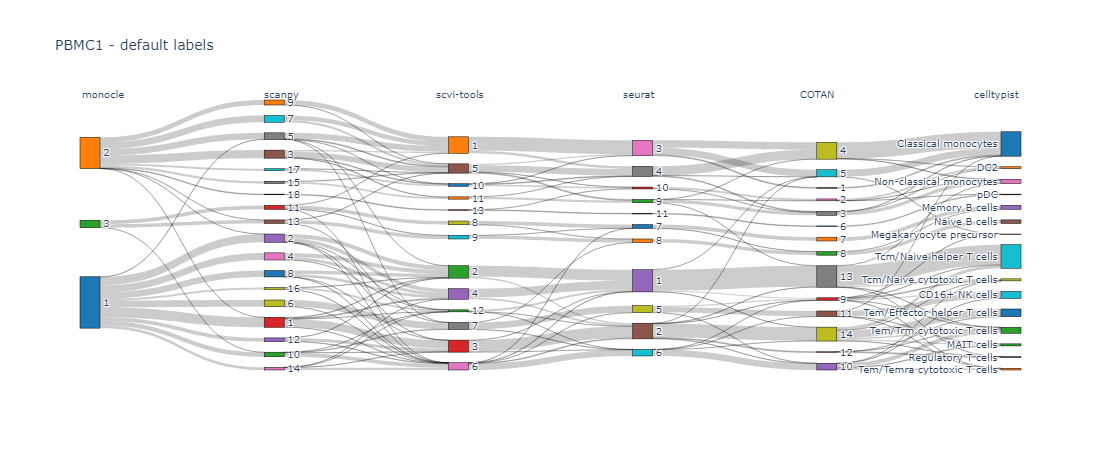

NMI       ARI  homogeneity  completeness  fowlkes_mallows
monocle     0.622344  0.439255     0.458549      0.968180         0.645589
scanpy      0.662480  0.389320     0.814398      0.558329         0.511739
scvi-tools  0.718265  0.557951     0.800919      0.651075         0.643426
seurat      0.747924  0.647338     0.787235      0.712353         0.712527
COTAN       0.727398  0.637277     0.792854      0.671926         0.705427

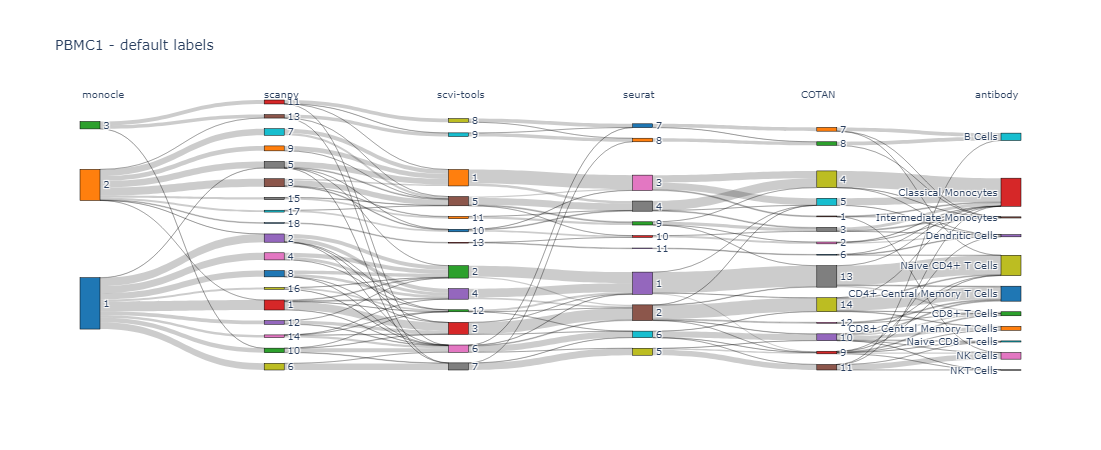

In [169]:
print_scores(tuning = 'default',dataset="PBMC1")

/tmp/ipykernel_72880/1013018177.py:66: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



'PBMC2 - number of clusters'

monocle  scanpy  scvi-tools  seurat  COTAN
0        2      18          20      14     17

'PBMC2 - Silhuette (higher is better)'

monocle    scanpy  scvi-tools    seurat    COTAN
0  0.224441  0.059225    0.000832  0.111509  0.12581

'PBMC2 - davies_bouldin (lower is better)'

monocle    scanpy  scvi-tools    seurat     COTAN
0  1.866736  2.073818    3.935702  1.630557  1.855098

'PBMC2 - default labels'

NMI       ARI  homogeneity  completeness  fowlkes_mallows
monocle     0.393166  0.207180     0.245998      0.978626         0.521364
scanpy      0.718820  0.457213     0.804000      0.649960         0.556684
scvi-tools  0.699788  0.424696     0.785920      0.630670         0.525031
seurat      0.775988  0.562430     0.819560      0.736815         0.640108
COTAN       0.729355  0.472800     0.745550      0.713848         0.562480

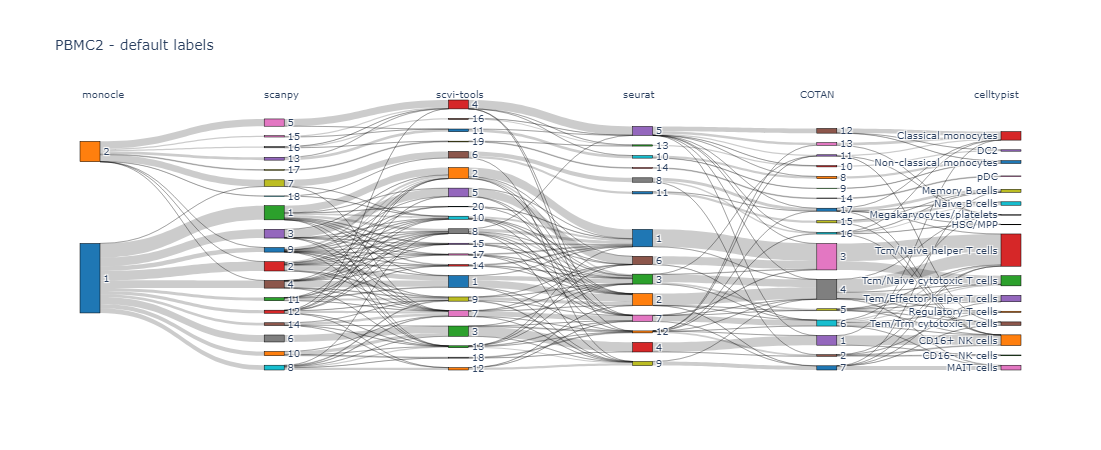

NMI       ARI  homogeneity  completeness  fowlkes_mallows
monocle     0.261544  0.093122     0.154169      0.861687         0.457589
scanpy      0.685644  0.523244     0.773965      0.615415         0.607208
scvi-tools  0.654391  0.485789     0.750936      0.579842         0.573975
seurat      0.748480  0.679377     0.793713      0.708124         0.734394
COTAN       0.703575  0.633882     0.697485      0.709773         0.704954

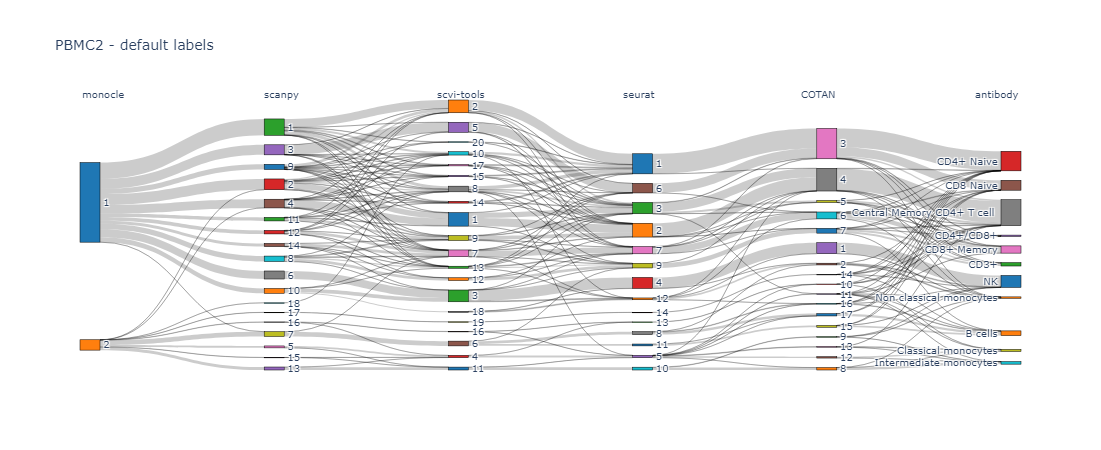

In [170]:
print_scores(tuning = 'default',dataset="PBMC2")

/tmp/ipykernel_72880/1013018177.py:66: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



'PBMC3 - number of clusters'

monocle  scanpy  scvi-tools  seurat  COTAN
0        3      22          17      18     32

'PBMC3 - Silhuette (higher is better)'

monocle    scanpy  scvi-tools    seurat     COTAN
0  0.171584  0.007616    0.055559  0.111834  0.092445

'PBMC3 - davies_bouldin (lower is better)'

monocle    scanpy  scvi-tools    seurat     COTAN
0  0.999779  2.376915    2.058343  1.698551  2.281481

'PBMC3 - default labels'

NMI       ARI  homogeneity  completeness  fowlkes_mallows
monocle     0.500696  0.233560     0.338609      0.960446         0.500077
scanpy      0.685919  0.462762     0.763719      0.622505         0.541286
scvi-tools  0.738418  0.579677     0.757237      0.720511         0.635237
seurat      0.770512  0.585110     0.821173      0.725738         0.644073
COTAN       0.723833  0.527470     0.849029      0.630815         0.609217

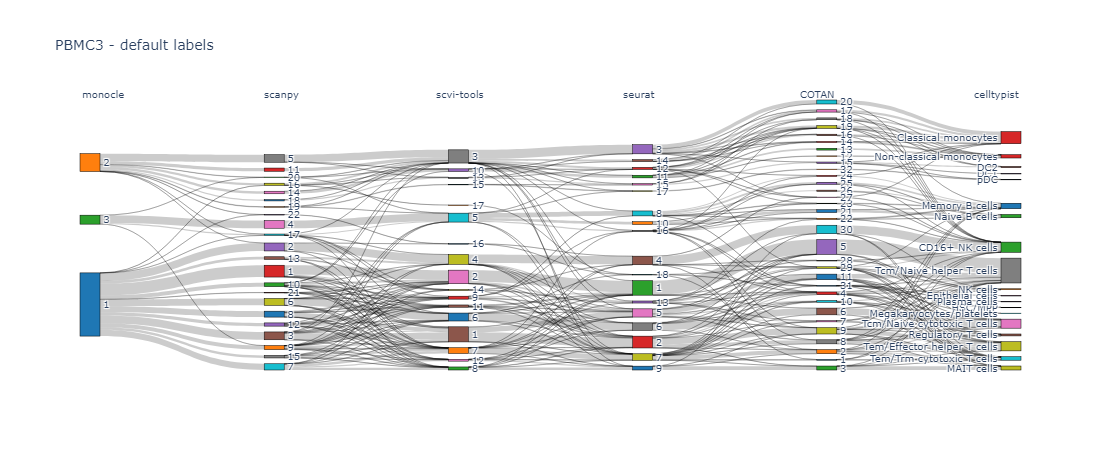

NMI       ARI  homogeneity  completeness  fowlkes_mallows
monocle     0.469679  0.196545     0.316293      0.911906         0.473204
scanpy      0.675464  0.545251     0.756553      0.610075         0.612243
scvi-tools  0.721883  0.667226     0.738229      0.706244         0.710211
seurat      0.749240  0.667468     0.798924      0.705374         0.712865
COTAN       0.677769  0.535850     0.798894      0.588538         0.606241

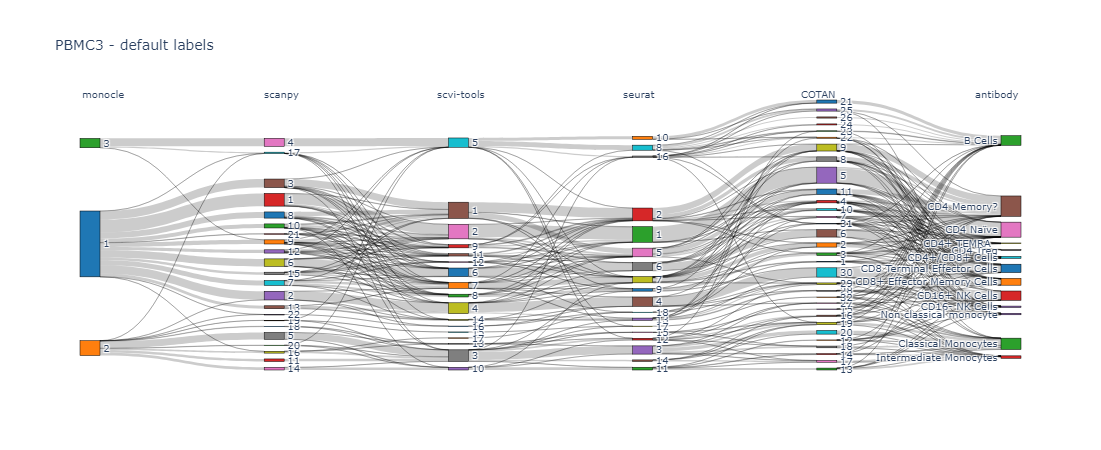

In [171]:
print_scores(tuning = 'default',dataset="PBMC3")

/tmp/ipykernel_72880/1013018177.py:66: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



'PBMC4 - number of clusters'

monocle  scanpy  scvi-tools  seurat  COTAN
0        3      22          16      19     24

'PBMC4 - Silhuette (higher is better)'

monocle    scanpy  scvi-tools    seurat     COTAN
0  0.081765  0.050853    0.061618  0.112255  0.103418

'PBMC4 - davies_bouldin (lower is better)'

monocle    scanpy  scvi-tools    seurat     COTAN
0  0.954689  2.100956    2.087707  1.442075  1.823095

'PBMC4 - default labels'

NMI       ARI  homogeneity  completeness  fowlkes_mallows
monocle     0.617025  0.470070     0.453383      0.965513         0.647279
scanpy      0.701228  0.380357     0.819943      0.612541         0.487560
scvi-tools  0.739299  0.504966     0.788229      0.696088         0.584900
seurat      0.760207  0.494746     0.847372      0.689301         0.583823
COTAN       0.716555  0.435917     0.808134      0.643618         0.526063

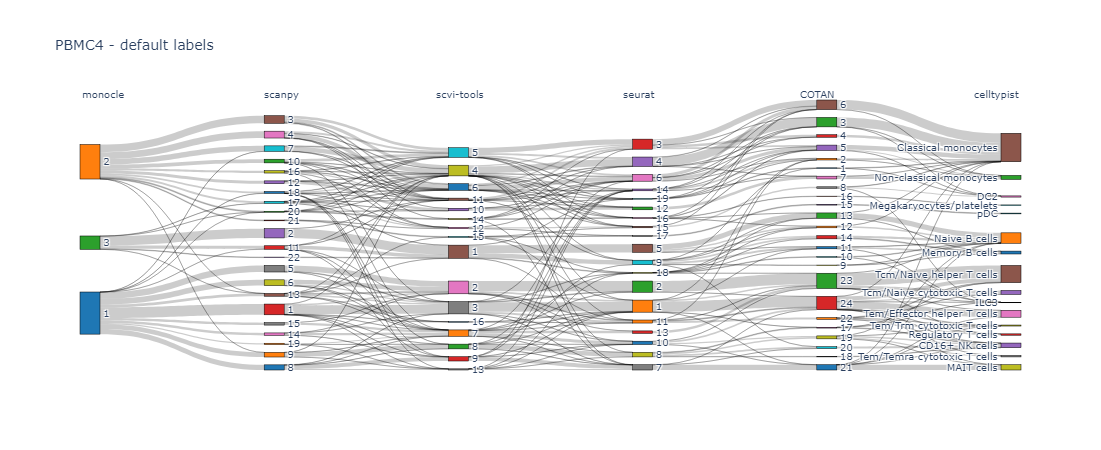

NMI       ARI  homogeneity  completeness  fowlkes_mallows
monocle     0.636102  0.525318     0.482349      0.933740         0.689338
scanpy      0.642165  0.368291     0.789153      0.541335         0.491476
scvi-tools  0.698167  0.482058     0.770861      0.638003         0.577373
seurat      0.691539  0.444871     0.803112      0.607186         0.550863
COTAN       0.625477  0.351843     0.733504      0.545185         0.461853

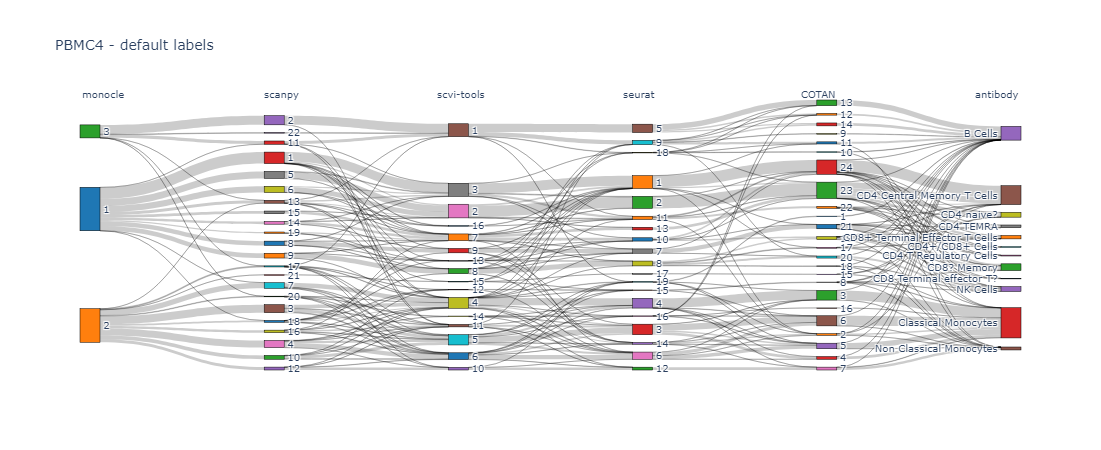

In [172]:
print_scores(tuning = 'default',dataset="PBMC4")

## Matching cellTypist clusters number

/tmp/ipykernel_72880/1013018177.py:66: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



'PBMC1 - number of clusters'

monocle  scanpy  scvi-tools  seurat  COTAN
0       18      17          20      21     14

'PBMC1 - Silhuette (higher is better)'

monocle    scanpy  scvi-tools    seurat    COTAN  celltypist
0  0.005501  0.050843    0.063871  0.088209  0.13383    0.090989

'PBMC1 - davies_bouldin (lower is better)'

monocle    scanpy  scvi-tools    seurat     COTAN  celltypist
0  2.83457  2.286672    2.797123  1.984746  1.728304    1.491801

'PBMC1 - matching celltypist labels'

NMI       ARI  homogeneity  completeness  fowlkes_mallows
monocle     0.658065  0.341945     0.757164      0.581903         0.448601
scanpy      0.735830  0.459735     0.822412      0.665742         0.553086
scvi-tools  0.699950  0.375082     0.808964      0.616828         0.479652
seurat      0.730468  0.423069     0.849278      0.640820         0.527386
COTAN       0.787289  0.670392     0.803876      0.771373         0.723485

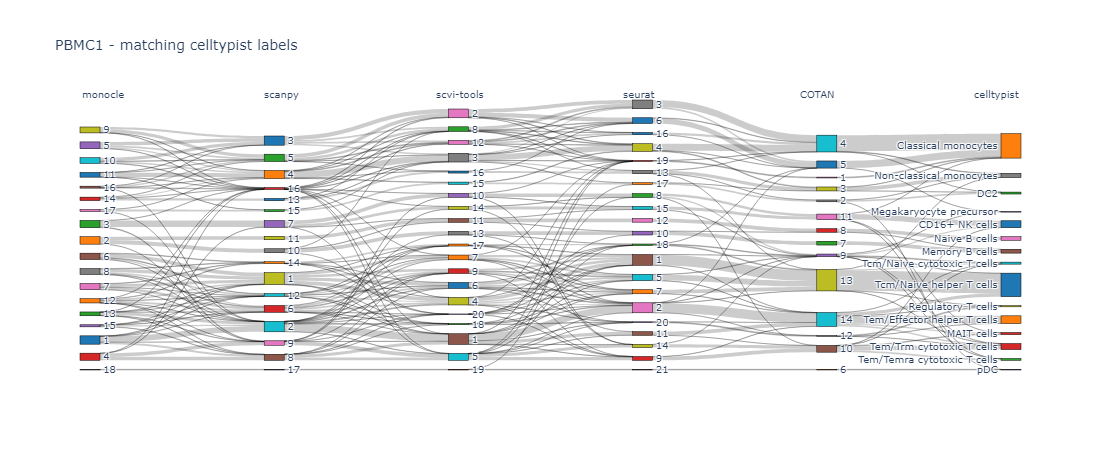

In [173]:
print_scores(tuning = 'celltypist',dataset="PBMC1")

/tmp/ipykernel_72880/1013018177.py:66: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



'PBMC2 - number of clusters'

monocle  scanpy  scvi-tools  seurat  COTAN
0       18      20          19      20     17

'PBMC2 - Silhuette (higher is better)'

monocle    scanpy  scvi-tools    seurat    COTAN  celltypist
0 -0.03374  0.025173    0.030773  0.060901  0.12581    0.131097

'PBMC2 - davies_bouldin (lower is better)'

monocle    scanpy  scvi-tools    seurat     COTAN  celltypist
0  3.167255  2.376025    3.431314  2.147939  1.855098    1.231923

'PBMC2 - matching celltypist labels'

NMI       ARI  homogeneity  completeness  fowlkes_mallows
monocle     0.605942  0.312112     0.699644      0.534375         0.425421
scanpy      0.697287  0.377675     0.809335      0.612491         0.492889
scvi-tools  0.709450  0.398779     0.791930      0.642531         0.500807
seurat      0.738307  0.418942     0.850535      0.652244         0.529176
COTAN       0.729355  0.472800     0.745550      0.713848         0.562480

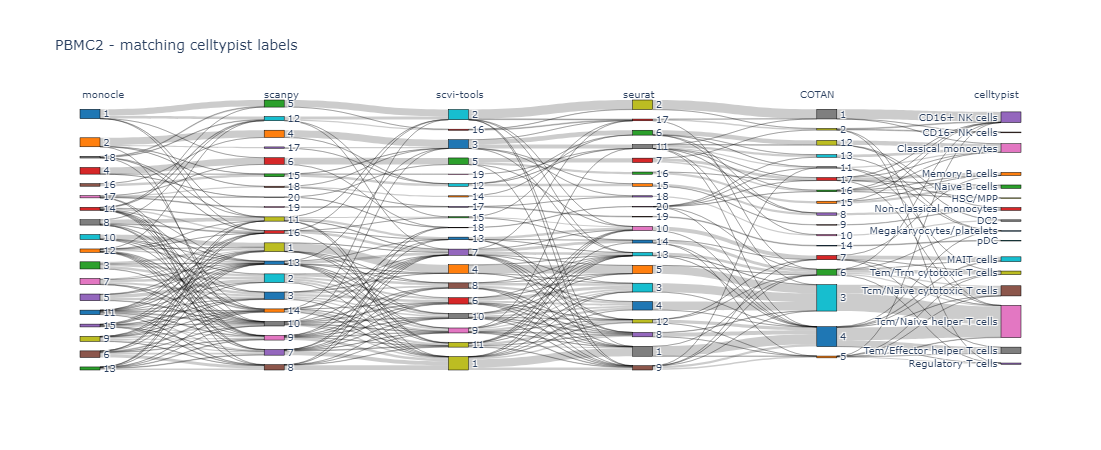

In [174]:
print_scores(tuning = 'celltypist',dataset="PBMC2")

/tmp/ipykernel_72880/1013018177.py:66: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



'PBMC3 - number of clusters'

monocle  scanpy  scvi-tools  seurat  COTAN
0       17      18          20      18     21

'PBMC3 - Silhuette (higher is better)'

monocle    scanpy  scvi-tools    seurat     COTAN  celltypist
0 -0.039293  0.040964    0.003634  0.112264  0.047585    0.130032

'PBMC3 - davies_bouldin (lower is better)'

monocle    scanpy  scvi-tools    seurat     COTAN  celltypist
0  3.778924  1.889045    2.221019  1.698481  2.344713    1.140713

'PBMC3 - matching celltypist labels'

NMI       ARI  homogeneity  completeness  fowlkes_mallows
monocle     0.593459  0.350206     0.643738      0.550465         0.432058
scanpy      0.712344  0.545918     0.758076      0.671816         0.609354
scvi-tools  0.735127  0.565025     0.767444      0.705423         0.623277
seurat      0.771047  0.586941     0.821567      0.726381         0.645653
COTAN       0.677393  0.470051     0.717462      0.641563         0.538494

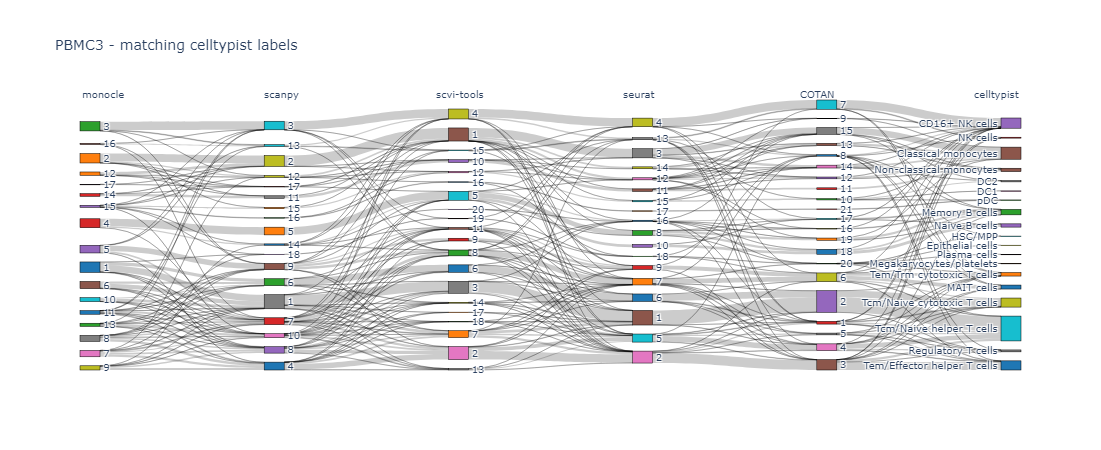

In [175]:
print_scores(tuning = 'celltypist',dataset="PBMC3")

/tmp/ipykernel_72880/1013018177.py:66: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



'PBMC4 - number of clusters'

monocle  scanpy  scvi-tools  seurat  COTAN
0       16      18          18      19     19

'PBMC4 - Silhuette (higher is better)'

monocle    scanpy  scvi-tools    seurat     COTAN  celltypist
0  0.022385  0.048061    0.107921  0.111704  0.098387    0.081772

'PBMC4 - davies_bouldin (lower is better)'

monocle    scanpy  scvi-tools    seurat     COTAN  celltypist
0  2.007518  1.898663    1.612564  1.442525  1.969481    1.194603

'PBMC4 - matching celltypist labels'

NMI       ARI  homogeneity  completeness  fowlkes_mallows
monocle     0.686019  0.421166     0.747399      0.633956         0.512728
scanpy      0.730100  0.473433     0.810168      0.664434         0.562407
scvi-tools  0.752718  0.500477     0.831022      0.687899         0.587099
seurat      0.759495  0.492528     0.846776      0.688525         0.581840
COTAN       0.724052  0.447103     0.782942      0.673402         0.532939

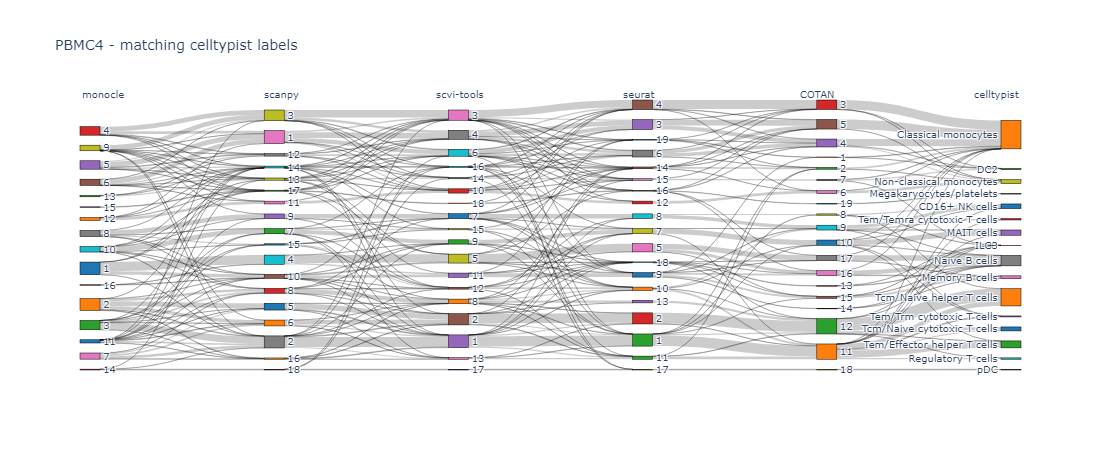

In [176]:
print_scores(tuning = 'celltypist',dataset="PBMC4")

## Matching antibody clusters number

/tmp/ipykernel_72880/1013018177.py:66: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



'PBMC1 - number of clusters'

monocle  scanpy  scvi-tools  seurat  COTAN
0        9      11          10      11     11

'PBMC1 - Silhuette (higher is better)'

monocle    scanpy  scvi-tools    seurat     COTAN  antibody
0  0.099643  0.073115    0.069687  0.150193  0.090531  0.047275

'PBMC1 - davies_bouldin (lower is better)'

monocle    scanpy  scvi-tools    seurat     COTAN  antibody
0  1.498221  1.689467    1.560514  1.392406  2.067883  1.794015

'PBMC1 - matching antibody labels'

NMI       ARI  homogeneity  completeness  fowlkes_mallows
monocle     0.724319  0.641765     0.727281      0.721381         0.707943
scanpy      0.746106  0.652841     0.792721      0.704669         0.717629
scvi-tools  0.757587  0.658079     0.782127      0.734540         0.721084
seurat      0.749425  0.642110     0.790860      0.712116         0.708375
COTAN       0.716421  0.637108     0.744518      0.690367         0.703698

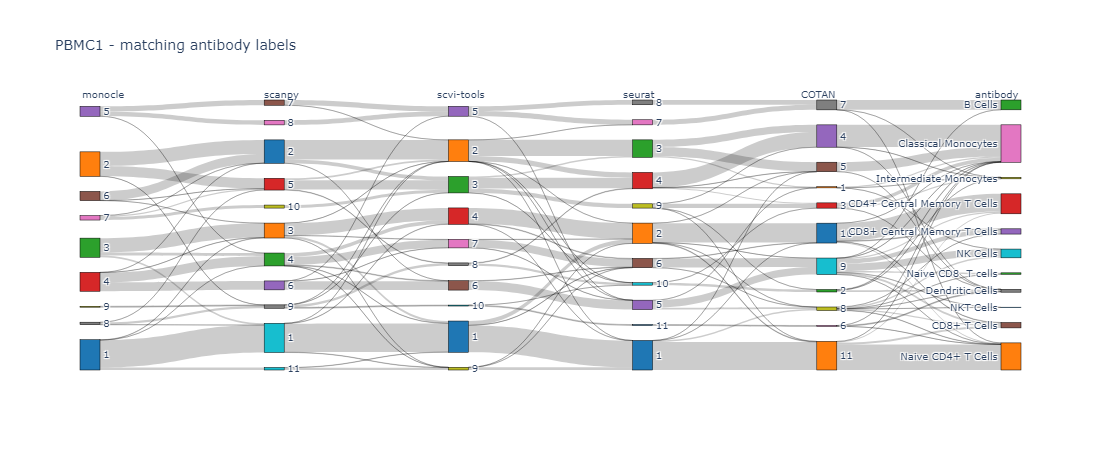

In [177]:
print_scores(tuning = 'antibody',dataset="PBMC1")

/tmp/ipykernel_72880/1013018177.py:66: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



'PBMC2 - number of clusters'

monocle  scanpy  scvi-tools  seurat  COTAN
0       11      10          12      12     12

'PBMC2 - Silhuette (higher is better)'

monocle    scanpy  scvi-tools    seurat     COTAN  antibody
0 -0.041184  0.037491   -0.021431  0.091472  0.074925  0.042144

'PBMC2 - davies_bouldin (lower is better)'

monocle    scanpy  scvi-tools    seurat     COTAN  antibody
0  3.22287  1.702317    4.327977  1.463008  2.077179    2.2928

'PBMC2 - matching antibody labels'

NMI       ARI  homogeneity  completeness  fowlkes_mallows
monocle     0.590346  0.458018     0.610332      0.571627         0.544156
scanpy      0.746517  0.649454     0.756633      0.736667         0.707302
scvi-tools  0.672359  0.576869     0.708154      0.640009         0.646073
seurat      0.759142  0.760752     0.776572      0.742477         0.800906
COTAN       0.735282  0.673070     0.687591      0.790082         0.743686

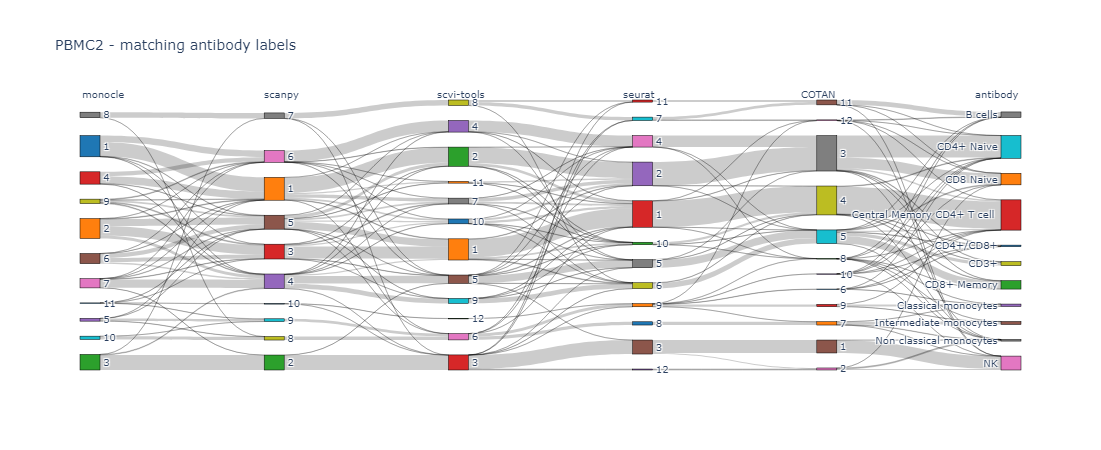

In [178]:
print_scores(tuning = 'antibody',dataset="PBMC2")

/tmp/ipykernel_72880/1013018177.py:66: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



'PBMC3 - number of clusters'

monocle  scanpy  scvi-tools  seurat  COTAN
0       12      14          13      14     12

'PBMC3 - Silhuette (higher is better)'

monocle    scanpy  scvi-tools    seurat    COTAN  antibody
0 -0.048747  0.024448   -0.007328  0.063501  0.05861  0.028552

'PBMC3 - davies_bouldin (lower is better)'

monocle    scanpy  scvi-tools    seurat     COTAN  antibody
0  3.082757  2.048357    2.967632  1.617082  1.813171  2.265731

'PBMC3 - matching antibody labels'

NMI       ARI  homogeneity  completeness  fowlkes_mallows
monocle     0.644484  0.537094     0.639574      0.649469         0.598577
scanpy      0.729603  0.683244     0.752370      0.708173         0.724410
scvi-tools  0.726492  0.670063     0.728625      0.724372         0.713239
seurat      0.764843  0.698339     0.799673      0.732920         0.738860
COTAN       0.691237  0.607331     0.643954      0.746015         0.676860

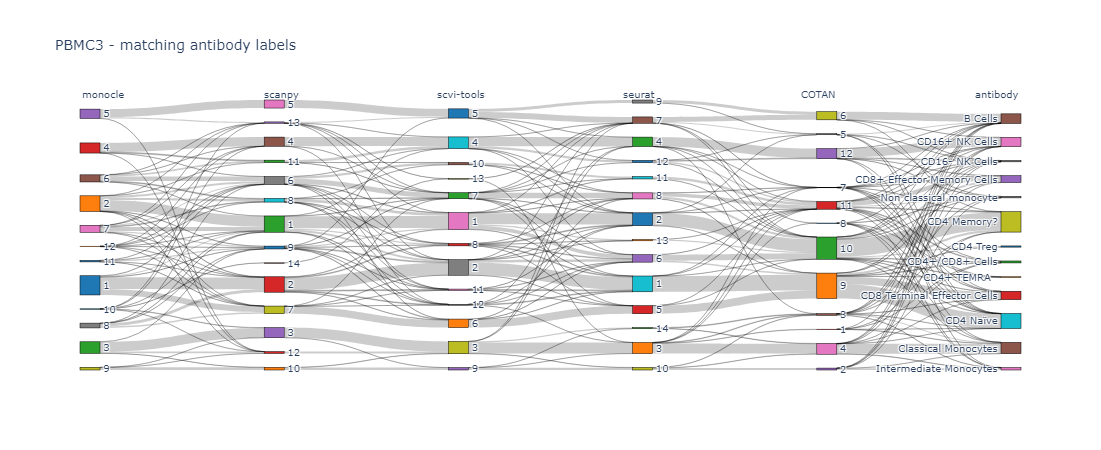

In [179]:
print_scores(tuning = 'antibody',dataset="PBMC3")

/tmp/ipykernel_72880/1013018177.py:66: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



'PBMC4 - number of clusters'

monocle  scanpy  scvi-tools  seurat  COTAN
0       13      11          11      13     12

'PBMC4 - Silhuette (higher is better)'

monocle    scanpy  scvi-tools    seurat    COTAN  antibody
0 -0.009349  0.036425    0.038929  0.059369  0.03044 -0.044213

'PBMC4 - davies_bouldin (lower is better)'

monocle    scanpy  scvi-tools    seurat     COTAN  antibody
0  2.412446  1.784603    1.670777  1.621226  1.822676  4.131438

'PBMC4 - matching antibody labels'

NMI       ARI  homogeneity  completeness  fowlkes_mallows
monocle     0.642736  0.462311     0.694650      0.598042         0.558509
scanpy      0.718317  0.585612     0.758534      0.682150         0.662578
scvi-tools  0.730060  0.588797     0.763135      0.699732         0.665395
seurat      0.722468  0.570140     0.785446      0.668840         0.651248
COTAN       0.675609  0.518293     0.678118      0.673118         0.606106

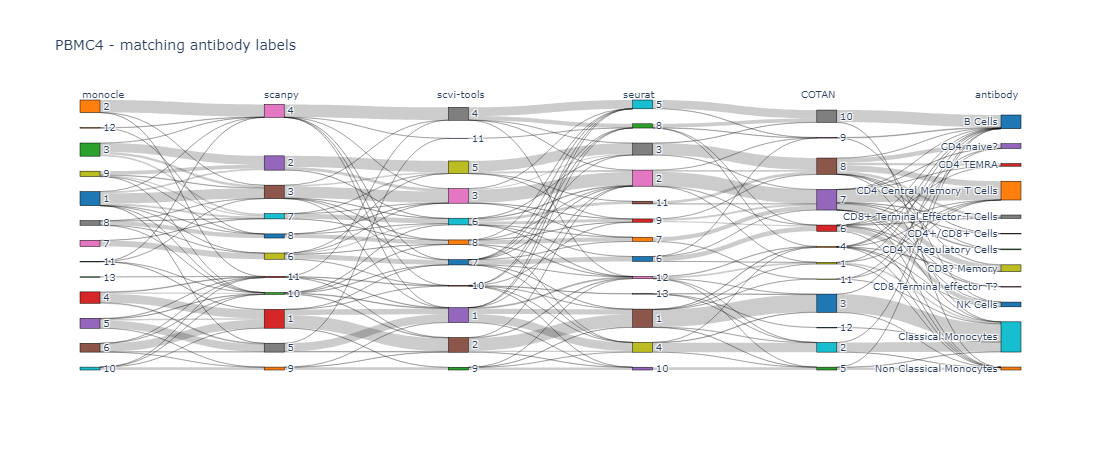

In [180]:
print_scores(tuning = 'antibody',dataset="PBMC4")

## Check cellTypist vs Antibody

In [181]:
def compute_clustering_scores(output_dir, dataset):#celltypist_df, antibody_df,
    # Merge the dataframes on the common 'cell' column
    #cotan_df = pd.read_csv(f'{DIR}{dataset}/COTAN/antibody/clustering_labels.csv', index_col=0)
    #display("Cotan clusters objetc dimension ",cotan_df.shape)
    #display("----------------------------------------")

    celltypist_df = pd.read_csv(f'{DIR}{dataset}/celltypist/celltypist_labels.csv', index_col=0)
    celltypist_df.index = celltypist_df.index.str[:-2]
    antibody_df = pd.read_csv(f'{DIR}{dataset}/antibody_annotation/antibody_labels_postproc.csv', index_col=0)
    #antibody_df = labels_df.merge(antibody_df, how='inner', on='cell')
    #all_in_antibody = celltypist_df.index.isin(antibody_df.index).all()
    #all_in_celltypist = antibody_df.index.isin(celltypist_df.index).all()

    #display("All celltypist indices in antibody: ",all_in_antibody, celltypist_df.index.isin(antibody_df.index).sum(),celltypist_df.shape)
    #display("All antibody indices in cellTypist:", all_in_celltypist)

    #display("----------------------------------------")
    
    merged_df = celltypist_df.merge(antibody_df, how='inner',left_index=True, right_index=True)# on='cell')

    merged_df.columns = ['cluster_celltypist','cluster_antibody']
    
    # Initialize scores dictionary
    scores = {
        'NMI': normalized_mutual_info_score(merged_df['cluster_celltypist'], merged_df['cluster_antibody'], average_method='arithmetic'),
        'ARI': adjusted_rand_score(merged_df['cluster_celltypist'], merged_df['cluster_antibody']),
        'Homogeneity': homogeneity_score(merged_df['cluster_celltypist'], merged_df['cluster_antibody']),
        'Completeness': completeness_score(merged_df['cluster_celltypist'], merged_df['cluster_antibody']),
        'Fowlkes_Mallows': fowlkes_mallows_score(merged_df['cluster_celltypist'], merged_df['cluster_antibody'])
    }
    
    # Convert scores to DataFrame
    scores_df = pd.DataFrame([scores])
    
    # Save scores to CSV and LaTeX
    #scores_df.to_csv(f'{output_dir}{dataset}/clustering_comparison_scores.csv')
    #scores_df.to_latex(f'{output_dir}{dataset}/clustering_comparison_scores.tex')
    
    # Display scores DataFrame
    display(scores_df)



In [182]:
for dataset in DATASET_NAMES:
    #display('------------------------------')
    display(f'{dataset} - Clustering Comparison between CellTypist and Antibody')

    # Assuming celltypist_df and antibody_df are defined elsewhere and available here
    compute_clustering_scores(DIR, dataset)


'PBMC1 - Clustering Comparison between CellTypist and Antibody'

NMI       ARI  Homogeneity  Completeness  Fowlkes_Mallows
0  0.752326  0.731095     0.708308      0.802178          0.78126

'PBMC2 - Clustering Comparison between CellTypist and Antibody'

NMI       ARI  Homogeneity  Completeness  Fowlkes_Mallows
0  0.659259  0.481537     0.667725      0.651004         0.585734

'PBMC3 - Clustering Comparison between CellTypist and Antibody'

NMI       ARI  Homogeneity  Completeness  Fowlkes_Mallows
0  0.693433  0.555502     0.693429      0.693436         0.618105

'PBMC4 - Clustering Comparison between CellTypist and Antibody'

NMI     ARI  Homogeneity  Completeness  Fowlkes_Mallows
0  0.751294  0.7252     0.728817      0.775201         0.776972

## Summary

### External measures

In [13]:
def load_scores(tuning, dataset):
    scores = pd.read_csv(f'{DIR}{dataset}/scores_{tuning}.csv')
    scores = scores.rename(columns={"Unnamed: 0": "tool"})
    scores['tuning'] = tuning
    return scores

/home/seriph/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:712: UserWarning:

Using the pointplot function without specifying `order` is likely to produce an incorrect plot.

/home/seriph/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



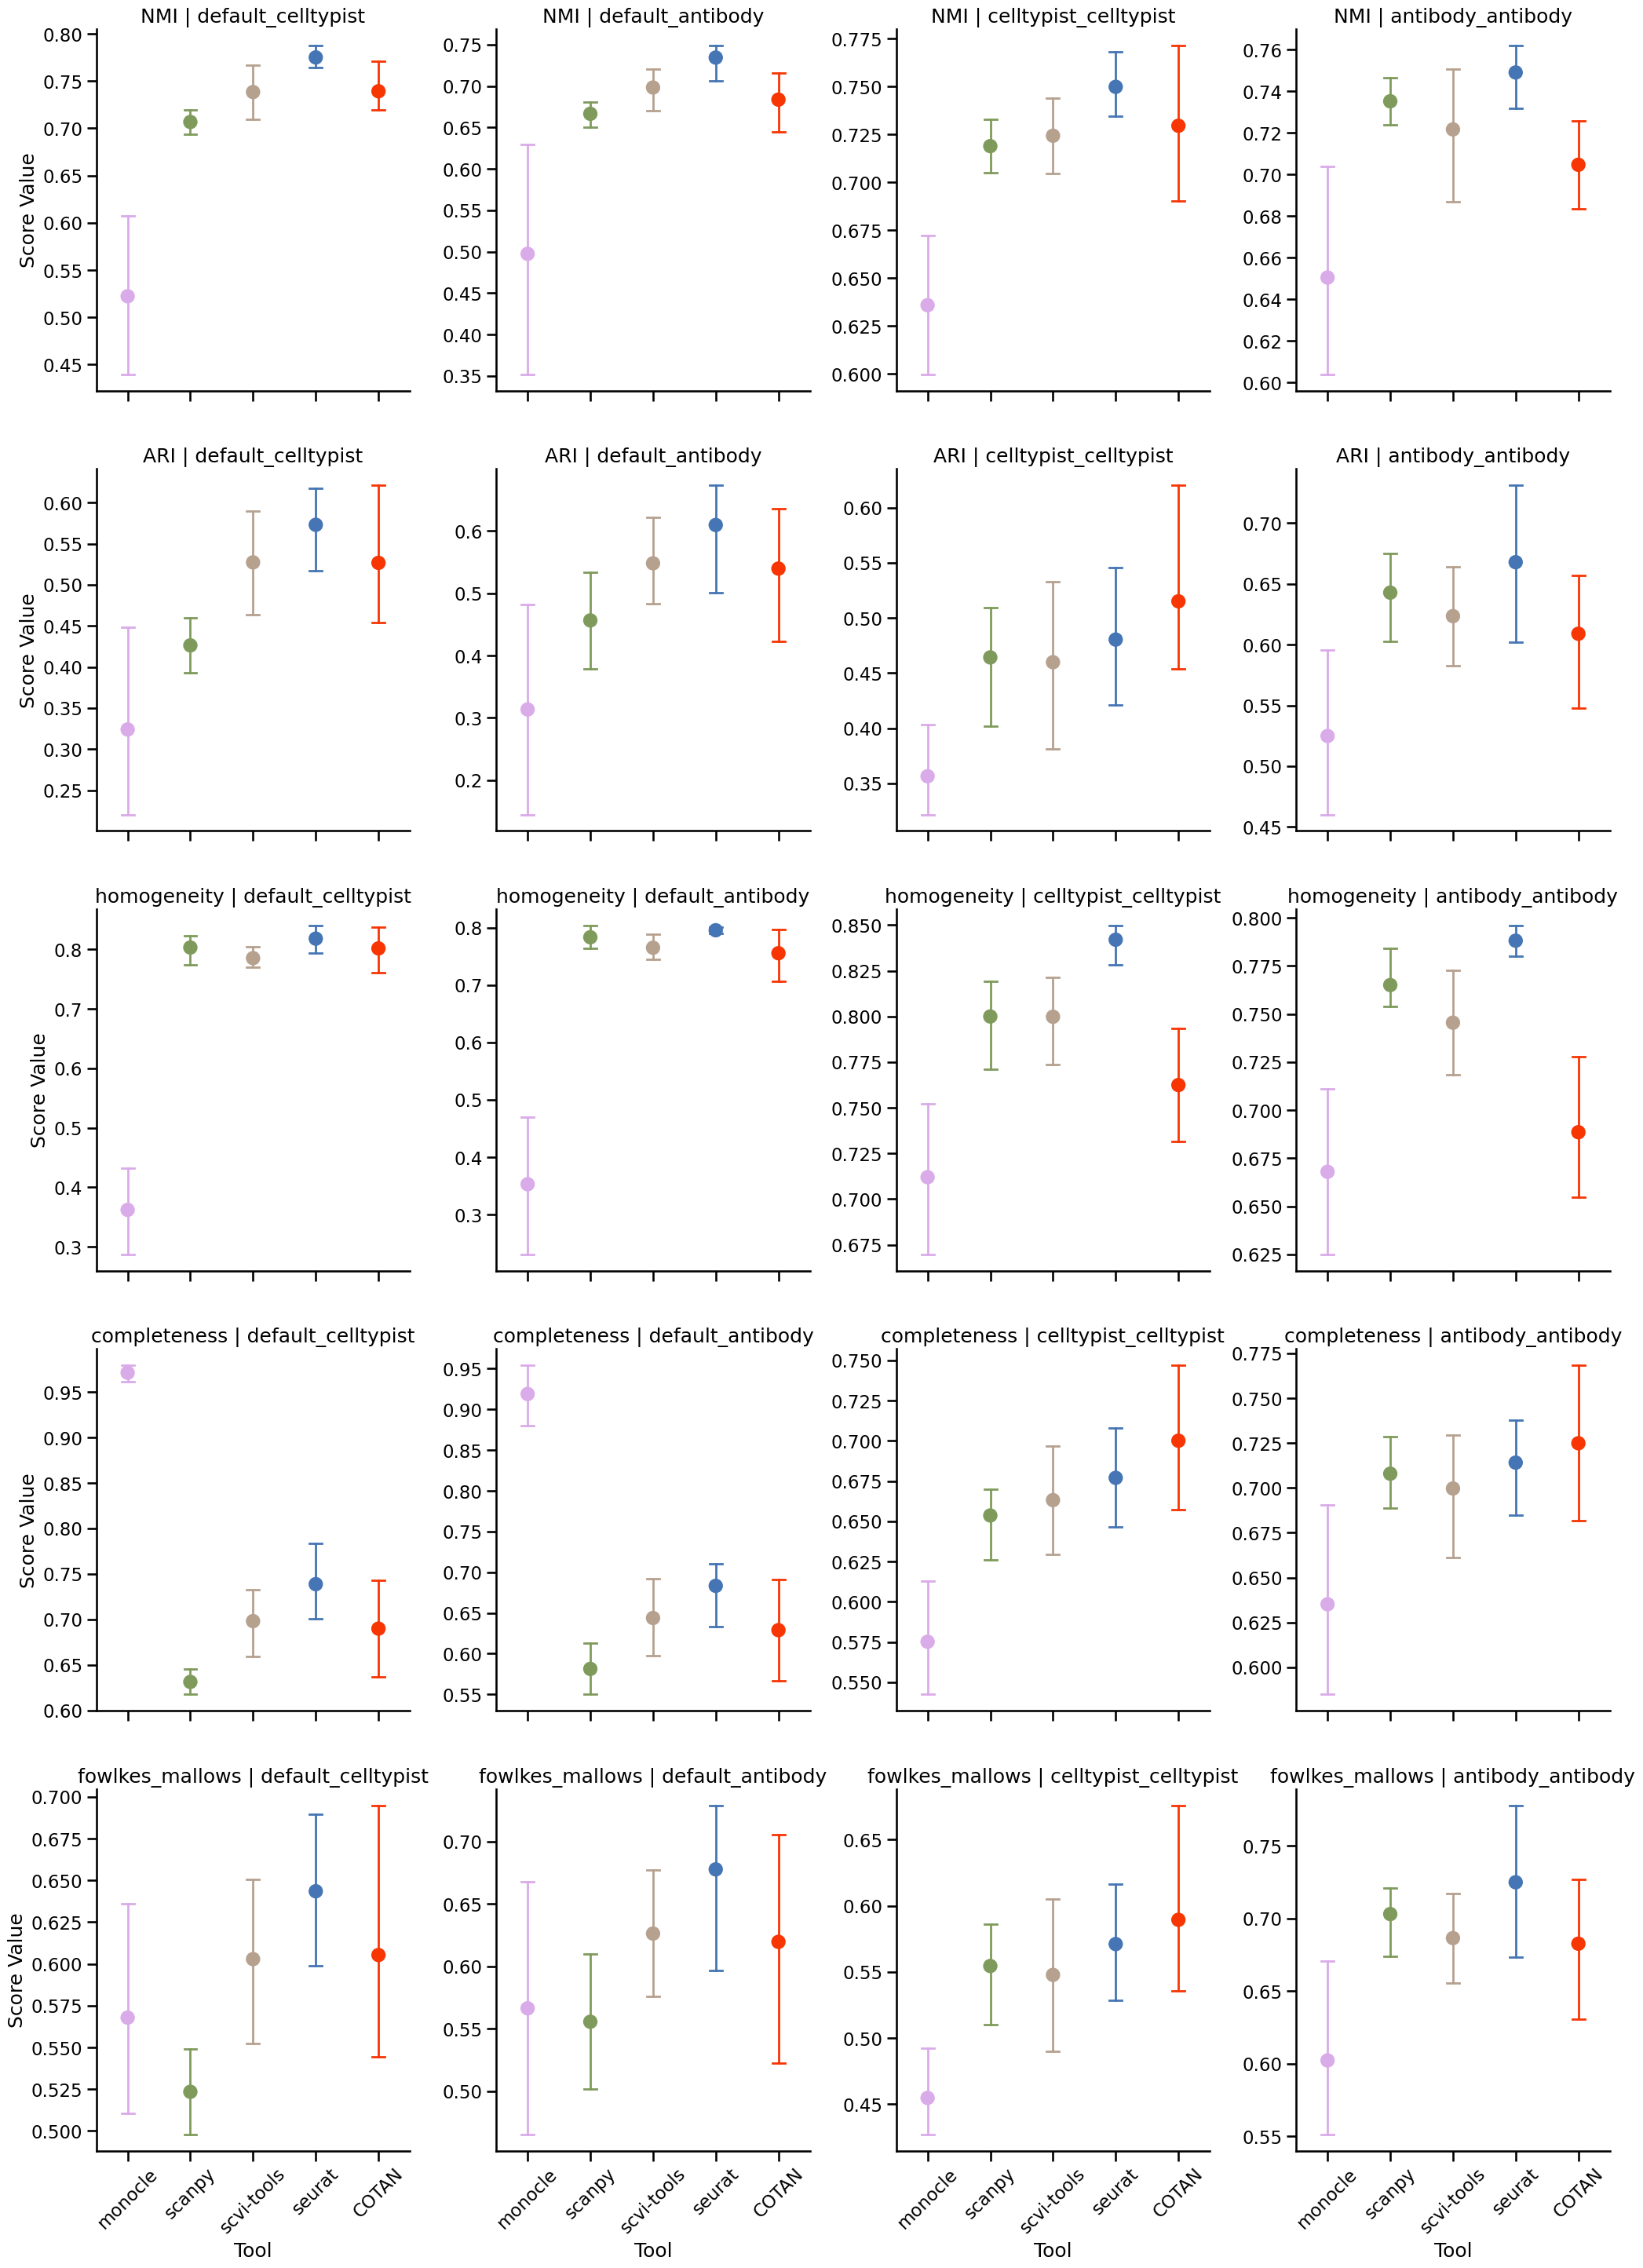

In [15]:
datasets = ['PBMC1', 'PBMC2', 'PBMC3', 'PBMC4']
tunings = ['default_celltypist', 'default_antibody', 'celltypist_celltypist', 'antibody_antibody']

scores_list = []

# Concatenate all scores into one DataFrame
for dataset in datasets:
    for tuning in tunings:
        scores = load_scores(tuning, dataset)
        scores['dataset'] = dataset
        scores_list.append(scores)

all_scores = pd.concat(scores_list)

# Prepare data for plotting
all_scores_melted = all_scores.melt(id_vars=['tool', 'tuning', 'dataset'], var_name='score', value_name='value')

sns.set_context("talk") 
# Define custom colors
custom_palette = { 
    "seurat": "#4575B4",
    "monocle": "#DAABE9",
    "scanpy": "#7F9B5C",
    "COTAN": "#F73604",
    "scvi-tools": "#B6A18F"
}

g = sns.FacetGrid(all_scores_melted, row='score', col='tuning', sharey=False, height=4, aspect=1.3)
g.map(sns.pointplot, 'tool', 'value', palette=custom_palette,capsize=0.2, errwidth=2)

# Set titles and labels
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set_axis_labels("Tool", "Score Value")
plt.subplots_adjust(top=1.4)
#g.fig.suptitle('Comparison of Clustering Tools by Various Scores and Conditions')
# Rotate x-axis labels
for ax in g.axes.flatten():
    plt.setp(ax.get_xticklabels(), rotation=45)

g.savefig("ClusteringToolsComparison.pdf")
plt.show()

### Internal measures

In [16]:
# Load your data (assuming you have CSV files for the scores)
def load_scores(tuning, dataset, score_type):
    file_path = f'{DIR}{dataset}/{tuning}_{score_type}.csv'
    print(f"Loading {file_path}")
    scores = pd.read_csv(file_path, header=0)  # Read the CSV file without an index column
    scores_melted = scores.melt(var_name='tool', value_name='value')
    scores_melted['tuning'] = tuning
    scores_melted['dataset'] = dataset
    scores_melted['score_type'] = score_type
    return scores_melted


Loading Data/PBMC1/default_silhouette.csv
Loading Data/PBMC1/default_davies_bouldin.csv
Loading Data/PBMC1/celltypist_silhouette.csv
Loading Data/PBMC1/celltypist_davies_bouldin.csv
Loading Data/PBMC1/antibody_silhouette.csv
Loading Data/PBMC1/antibody_davies_bouldin.csv
Loading Data/PBMC2/default_silhouette.csv
Loading Data/PBMC2/default_davies_bouldin.csv
Loading Data/PBMC2/celltypist_silhouette.csv
Loading Data/PBMC2/celltypist_davies_bouldin.csv
Loading Data/PBMC2/antibody_silhouette.csv
Loading Data/PBMC2/antibody_davies_bouldin.csv
Loading Data/PBMC3/default_silhouette.csv
Loading Data/PBMC3/default_davies_bouldin.csv
Loading Data/PBMC3/celltypist_silhouette.csv
Loading Data/PBMC3/celltypist_davies_bouldin.csv
Loading Data/PBMC3/antibody_silhouette.csv
Loading Data/PBMC3/antibody_davies_bouldin.csv
Loading Data/PBMC4/default_silhouette.csv
Loading Data/PBMC4/default_davies_bouldin.csv
Loading Data/PBMC4/celltypist_silhouette.csv
Loading Data/PBMC4/celltypist_davies_bouldin.csv
Lo

/home/seriph/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight

/home/seriph/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



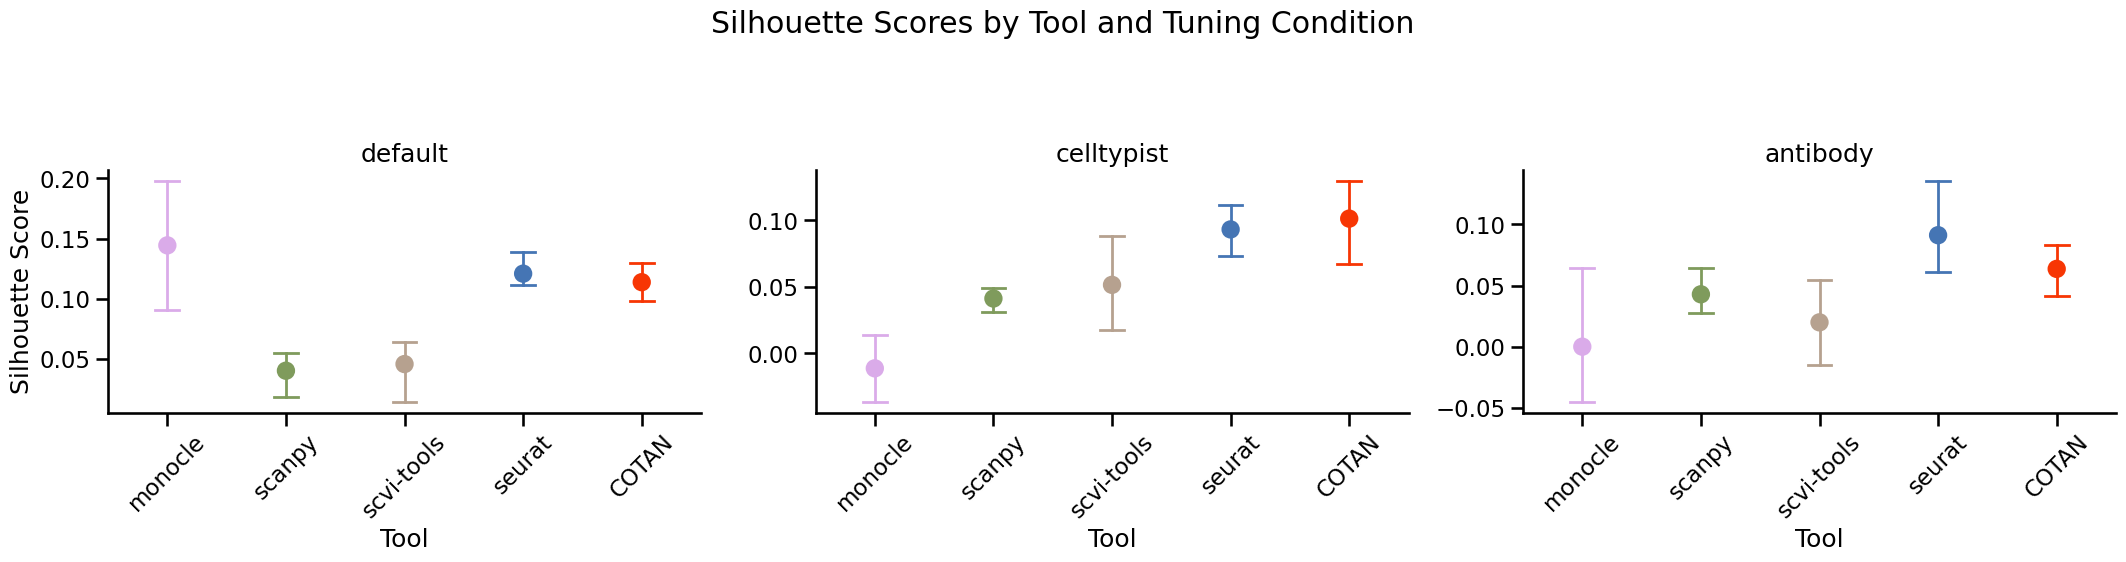

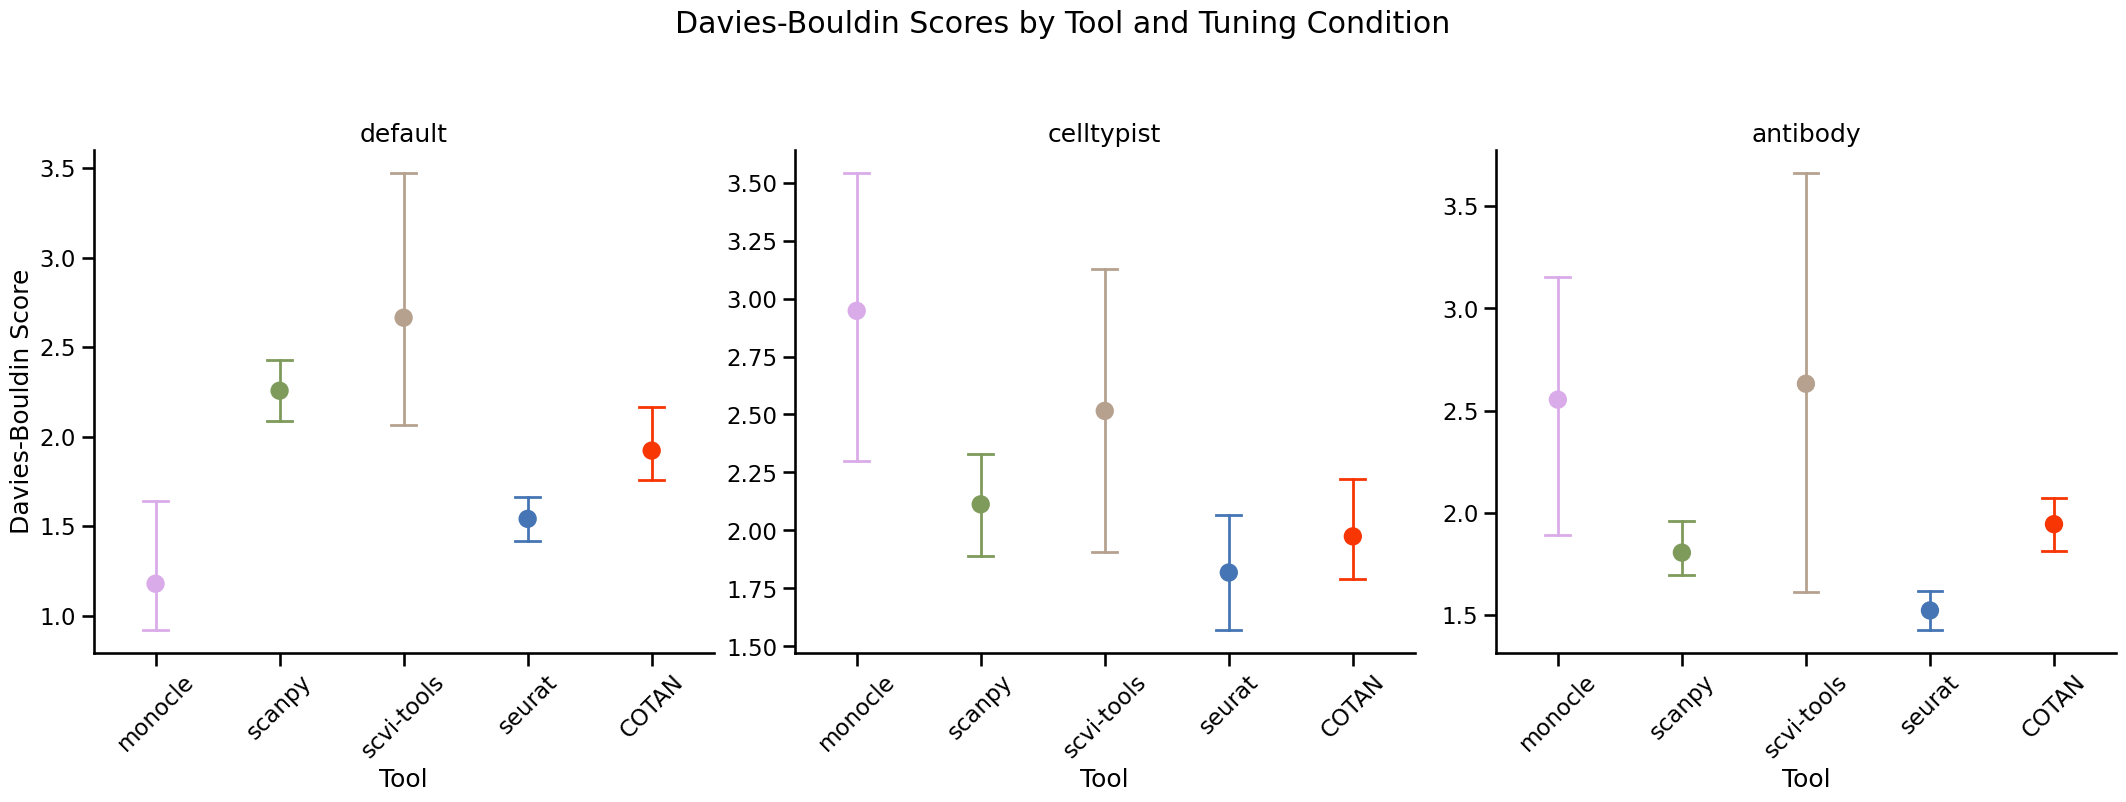

In [17]:

datasets = ['PBMC1', 'PBMC2', 'PBMC3', 'PBMC4']
tunings = ['default', 'celltypist', 'antibody']
score_types = ['silhouette', 'davies_bouldin']
scores_list = []

# Concatenate all scores into one DataFrame
for dataset in datasets:
    for tuning in tunings:
        for score_type in score_types:
            scores = load_scores(tuning, dataset, score_type)
            scores_list.append(scores)

all_scores = pd.concat(scores_list)

# Debug: Check the loaded data
print(all_scores.head())

# Define custom colors
custom_palette = {
    "seurat": "#4575B4",
    "monocle": "#DAABE9",
    "scanpy": "#7F9B5C",
    "COTAN": "#F73604",
    "scvi-tools": "#B6A18F"
}

# Filter for silhouette and davies_bouldin scores
silhouette_scores = all_scores[all_scores['score_type'] == 'silhouette']
davies_bouldin_scores = all_scores[all_scores['score_type'] == 'davies_bouldin']

# Plot Silhouette scores
g1 = sns.FacetGrid(silhouette_scores, col='tuning', sharey=False, height=4, aspect=1.8)
g1.map(sns.pointplot, 'tool', 'value', palette=custom_palette, order=[ "monocle", "scanpy", "scvi-tools","seurat","COTAN"],capsize=0.2, errwidth=2)
g1.set_titles(col_template="{col_name}")
g1.set_axis_labels("Tool", "Silhouette Score")
g1.fig.suptitle('Silhouette Scores by Tool and Tuning Condition', y=1.25)
plt.subplots_adjust(top=0.85)
# Rotate x-axis labels
for ax in g1.axes.flatten():
    plt.setp(ax.get_xticklabels(), rotation=45)

# Plot Davies-Bouldin scores
g2 = sns.FacetGrid(davies_bouldin_scores, col='tuning', sharey=False, height=4, aspect=1.8)
g2.map(sns.pointplot, 'tool', 'value', palette=custom_palette, order=["monocle", "scanpy",  "scvi-tools","seurat","COTAN"],capsize=0.2, errwidth=2)
g2.set_titles(col_template="{col_name}")
g2.set_axis_labels("Tool", "Davies-Bouldin Score")
g2.fig.suptitle('Davies-Bouldin Scores by Tool and Tuning Condition', y=1.85)
plt.subplots_adjust(top=1.5)
# Rotate x-axis labels
for ax in g2.axes.flatten():
    plt.setp(ax.get_xticklabels(), rotation=45)

g1.savefig("ClusteringToolsSilhouette.png")
g2.savefig("ClusteringToolsDaviesBouldin.png")

plt.show()
